In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle
import stimgenerate as sg
import matplotlib.patches as mpatches
import pandas as pd
import scipy.stats as stats
import matplotlib.patches as patches
from neo.core import SpikeTrain
from quantities import ms
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
from scipy.integrate import simpson
import random

from matplotlib import cm
from matplotlib.colors import ListedColormap


# Load data

In [2]:
res_file = r"results/091825B_results.mat"
f = h5py.File(res_file)
for cell in f['results']['NaturalMovingObjectAndFlash'][1:]:
    if len(f[cell[0]]) < 20:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []
    motion_seed_n = []
    motion_seed_c = []    
    spike_indices_n = []
    spike_indices_c = []
    epoch_id_n = []
    epoch_id_c = []
    trans_x_n = []
    trans_y_n = []
    trans_x_c = []
    trans_y_c = []
    trajx_f = []
    trajy_f = []
    motion_seed_f = []
    spike_indices_f = []
    epoch_id_f = []
    trans_x_f = []
    trans_y_f = []

    for cx,cy,si,t,s,en,tx,ty in zip(f[cell[0]]['cx'][0][:], f[cell[0]]['cy'][0][:],f[cell[0]]['spike_indices'][0][:], f[cell[0]]['cur_motion_type'][0][:], f[cell[0]]['motion_seed'][0][:], f[cell[0]]['epoch_id'][0][:],f[cell[0]]['trans_x'][0][:],f[cell[0]]['trans_y'][0][:]):
        # if f[s][:][0] <201 or f[s][:][0] > 300:
        #     continue

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            motion_seed_n.extend(f[s][:])
            spike_indices_n.append(f[si][:])
            epoch_id_n.append(f[en][:])
            trans_y_n.extend(f[ty][:])
            trans_x_n.extend(f[tx][:])

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'control':
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            motion_seed_c.extend(f[s][:])
            spike_indices_c.append(f[si][:])
            epoch_id_c.append(f[en][:])
            trans_x_c.extend(f[tx][:])
            trans_y_c.extend(f[ty][:])

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'flash':
            trajx_f.extend(f[cx][:])
            trajy_f.extend(f[cy][:])
            motion_seed_f.extend(f[s][:])
            spike_indices_f.append(f[si][:])
            epoch_id_f.append(f[en][:])
            trans_x_f.extend(f[tx][:])
            trans_y_f.extend(f[ty][:])
    break # only use the first cell, for this example



trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)
trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)
trajx_f = np.asarray(trajx_f)
trajy_f = np.asarray(trajy_f)
motion_seed_n = np.asarray(motion_seed_n)
motion_seed_c = np.asarray(motion_seed_c)
motion_seed_f = np.asarray(motion_seed_f)
epoch_id_n = np.asarray(epoch_id_n)
epoch_id_c = np.asarray(epoch_id_c)
epoch_id_f = np.asarray(epoch_id_f)
trans_x_n = np.asarray(trans_x_n)
trans_x_c = np.asarray(trans_x_c)
trans_x_f = np.asarray(trans_x_f)
trans_y_n = np.asarray(trans_y_n)
trans_y_c = np.asarray(trans_y_c)
trans_y_f = np.asarray(trans_y_f)
trajx_n = trajx_n + trans_x_n
trajy_n = trajy_n + trans_y_n
trajx_c = trajx_c + trans_x_c
trajy_c = trajy_c + trans_y_c
trajx_f = trajx_f + trans_x_f
trajy_f = trajy_f + trans_y_f

cells_n = []
for i in range(len(trans_x_n)):
    if trans_x_n[i] == 0:
        cells_n.append(1)
    if trans_x_n[i] == 84:
        if trans_y_n[i] > 0:
            cells_n.append(3)
        if trans_y_n[i] < 0:
            cells_n.append(7)
    if trans_x_n[i] == 168:
        cells_n.append(2)
    if trans_x_n[i] == -84:
        if trans_y_n[i] > 0:
            cells_n.append(4)
        if trans_y_n[i] < 0:
            cells_n.append(6)
    if trans_x_n[i] == -168:
        cells_n.append(5)

cells_c = []
for i in range(len(trans_x_c)):
    if trans_x_c[i] == 0:
        cells_c.append(1)
    if trans_x_c[i] == 84:
        if trans_y_c[i] > 0:
            cells_c.append(3)
        if trans_y_c[i] < 0:
            cells_c.append(7)
    if trans_x_c[i] == 168:
        cells_c.append(2)
    if trans_x_c[i] == -84:
        if trans_y_c[i] > 0:
            cells_c.append(4)
        if trans_y_c[i] < 0:
            cells_c.append(6)
    if trans_x_c[i] == -168:
        cells_c.append(5)

cells_f = []
for i in range(len(trans_x_f)):
    if trans_x_f[i] == 0:
        cells_f.append(1)
    if trans_x_f[i] == 84:
        if trans_y_f[i] > 0:
            cells_f.append(3)
        if trans_y_f[i] < 0:
            cells_f.append(7)
    if trans_x_f[i] == 168:
        cells_f.append(2)
    if trans_x_f[i] == -84:
        if trans_y_f[i] > 0:
            cells_f.append(4)
        if trans_y_f[i] < 0:
            cells_f.append(6)
    if trans_x_f[i] == -168:
        cells_f.append(5)

cells_n = np.asarray(cells_n)
cells_c = np.asarray(cells_c)
cells_f = np.asarray(cells_f)

In [3]:
# with open('results/spike_indices_nc2V3.pkl', 'wb') as f:
#     pickle.dump(spike_indices_n, f)
# with open('results/spike_indices_cc2V3.pkl', 'wb') as f:
#     pickle.dump(spike_indices_c, f)
# with open('results/spike_indices_fc2V3.pkl', 'wb') as f:
#     pickle.dump(spike_indices_f, f)

In [4]:
def block_stats_all(matrix, n_real):

    real_real = matrix[0:n_real, 0:n_real]
    real_model = matrix[0:n_real, n_real:]
    model_model = matrix[n_real:, n_real:]
    
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
    return stats


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=0.2, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))


def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2
def biphasic_temporal_filter_norm0(t, p1, p2, tau1, tau2, n):
    # Ensure t as positive duration array
    t = np.asarray(-t, dtype=float)
    # Compute the two cascaded low-pass terms
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    # Combine to biphasic raw filter
    filt = term1 - term2

    area = simpson(filt, t)
    filt -= area / (t[-1] - t[0])
    return filt
def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   
    T, Y, X = noise_input.shape 
    noise_input = noise_input.astype(np.float32)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)
    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))

    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)

    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")

# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v

def load_data(filename='optimization batch/V2_natural_counts.pkl'):
    """Load the optimization results"""
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"✓ Successfully loaded {filename}")
        return data
    except FileNotFoundError:
        print(f"✗ File {filename} not found")
        return None
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")
        return None

def plot_optimization_convergence(data, title="Optimization Convergence"):
    """Plot only the optimization convergence"""
    if not isinstance(data, dict):
        print("Data is not a dictionary")
        return
    
    # Check for optimization data
    iterations = data.get('iterationsC', [])
    train_errors = data.get('errors_trainC', [])
    eval_errors = data.get('errors_evalC', [])
    
    if not iterations or not train_errors:
        print("No optimization data found")
        return
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_errors, 'b-', label='Training Error', linewidth=2, marker='o', markersize=1)
    if eval_errors:
        plt.plot(iterations, eval_errors, 'r-', label='Evaluation Error', linewidth=2, marker='s', markersize=1)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'results/{title}_optimization_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Optimization convergence plot saved as '{title}_optimization_convergence.png'")

def print_parameters(data):
    """Print optimal parameters as text"""
    if not isinstance(data, dict):
        print("Data is not a dictionary")
        return
    
    # Check for different possible parameter keys
    optimal_params = data.get('optimal_params', [])
    if not np.any(optimal_params):
        optimal_params = data.get('params', [])
    if not np.any(optimal_params):
        optimal_params = data.get('best_params', [])
    if not np.any(optimal_params):
        optimal_params = data.get('final_params', [])
    
    if not np.any(optimal_params):
        print("No optimal parameters found")
        print("Available keys in data:", list(data.keys()))
        return
    
    # Parameter names based on the optimization setup
    param_names = ['B', 'tau', 'p1', 'p2', 'tau1', 'tau2', 'gain', 'max_rate', 'y', 'theta']
    
    print("\n" + "="*50)
    print("OPTIMAL PARAMETERS")
    print("="*50)
    
    if len(optimal_params) == len(param_names):
        for name, value in zip(param_names, optimal_params):
            print(f"{name:10s}: {value:.6f}")
    else:
        for i, value in enumerate(optimal_params):
            print(f"Parameter {i:2d}: {value:.6f}")
    
    print("="*50)

def print_summary(data):
    """Print a comprehensive summary of the results"""
    if not isinstance(data, dict):
        print("Data is not a dictionary")
        return
    
    print("\n" + "="*60)
    print("COMPREHENSIVE OPTIMIZATION SUMMARY")
    print("="*60)
    

    
    # Optimization summary
    iterations = data.get('iterationsC', [])
    train_errors = data.get('errors_trainC', [])
    eval_errors = data.get('errors_evalC', [])
    
    if iterations and train_errors:
        print(f"\n📊 OPTIMIZATION PERFORMANCE:")
        print(f"   Total iterations: {len(iterations)}")
        print(f"   Initial training error: {train_errors[0]:.6f}")
        print(f"   Final training error: {train_errors[-1]:.6f}")
        print(f"   Error reduction: {((train_errors[0] - train_errors[-1]) / train_errors[0] * 100):.2f}%")
        
        if eval_errors:
            print(f"   Initial evaluation error: {eval_errors[0]:.6f}")
            print(f"   Final evaluation error: {eval_errors[-1]:.6f}")
            print(f"   Overfitting indicator: {train_errors[-1] - eval_errors[-1]:.6f}")
    
    # Timing summary
    timing_summary = data.get('timing_summary', {})
    if timing_summary:
        print(f"\n⏱️  TIMING SUMMARY:")
        total_time = sum(timing_summary.values())
        print(f"   Total computation time: {total_time:.3f} seconds")
        
        # Find slowest step
        slowest_step = max(timing_summary.items(), key=lambda x: x[1])
        print(f"   Slowest step: {slowest_step[0]} ({slowest_step[1]:.3f}s)")
        
        # Find fastest step
        fastest_step = min(timing_summary.items(), key=lambda x: x[1])
        print(f"   Fastest step: {fastest_step[0]} ({fastest_step[1]:.3f}s)")
    
    # GPU information
    gpu_available = data.get('gpu_available', False)
    print(f"\n🖥️  HARDWARE INFO:")
    print(f"   GPU acceleration: {'✓ Available' if gpu_available else '✗ Not available'}")
    
    print("\n" + "="*60)

def plot_distance_bar(NCompareEmd, seeds_min, seeds_max, label, title):
    meansemd  = np.nanmean(NCompareEmd, axis=0)[::-1]
    stdsemd   = np.nanstd(NCompareEmd, axis=0, ddof=0)[::-1]

    cell_labels  = [f'Cell {i}' for i in range(1,8)]
    cell_labels = cell_labels[::-1]

    fig = plt.figure(figsize=(20, 6))
    gs  = fig.add_gridspec(1, 2, width_ratios=[5, 2], wspace=0.1)

    ax0 = fig.add_subplot(gs[0, 0])
    im  = ax0.imshow(
        NCompareEmd.T,
        cmap='viridis',
        aspect='auto',
        origin='lower',
        extent=[seeds_min, seeds_max, 1, 7]
    )
    cbar = fig.colorbar(im, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label(label, fontsize=20)
    cbar.ax.tick_params(labelsize=16)
    ax0.set_xlabel('Seed', fontsize=20)
    ax0.set_ylabel('Cell index', fontsize=20)
    ax0.set_title(title, fontsize=24, pad =  20)
    ax0.tick_params(axis='both', which='major', labelsize=16)

    # Bar graph for mean with std error bars only
    ax1 = fig.add_subplot(gs[0, 1])
    indices = np.arange(len(cell_labels))
    bar_width = 0.5

    bars = ax1.barh(indices, meansemd, xerr=stdsemd, height=bar_width, color='firebrick', capsize=8, label='Mean ± Std')

    ax1.set_yticks(indices)
    ax1.set_yticklabels(cell_labels, fontsize=18)
    ax1.invert_yaxis()

    ax1.set_title('Mean ± Std', fontsize=22,pad = 20)

    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    ax1.tick_params(axis='x', labelsize=16)

    plt.tight_layout(pad = 15)
    plt.show()

# Parameter Natural

In [5]:
sigmas_c = np.load('results/V3_control_counts_sigmas.npz', allow_pickle=True)
sigmas_n = np.load('results/V3_natural_counts_sigmas.npz', allow_pickle=True)


FileNotFoundError: [Errno 2] No such file or directory: 'results/V3_control_counts_sigmas.npz'

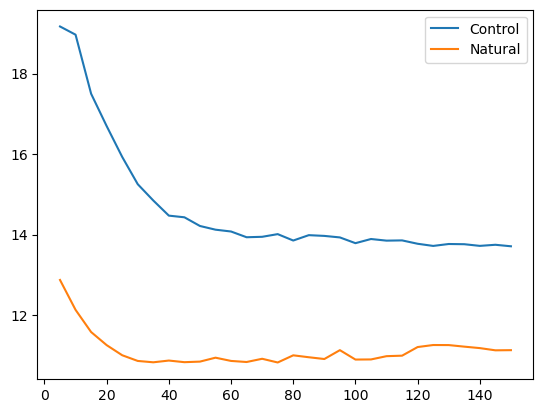

In [47]:
plt.plot(sigmas_c['sigmas'],sigmas_c["scores"],label='Control')
plt.plot(sigmas_n['sigmas'],sigmas_n["scores"],label='Natural')
plt.legend()
plt.show()

In [10]:
delay = 0.05 # s
time_para = 5400 # time bin to generate spike
time_bin = 1 / time_para
q = 1.0 / (100.0 * pq.ms)  
t_sampling = np.linspace(0,90,90)
t_temporal = np.linspace(-2000/3,0, 40) 

random.seed(42)
all_indices = list(range(679))
random.shuffle(all_indices)
train_indices = all_indices[:339]
eval_indices = all_indices[339:]

x_SF = np.linspace(-200, 200, 401).astype(int)
y_SF = np.linspace(-200, 200, 401).astype(int)
X_SF, Y_SF = np.meshgrid(x_SF, y_SF) 


# Parameter settting for model

A       = 1
n       =3


# parameter for natural
B_n       = 0.0006787207943439143
tau_n     = 17.280863664729115
p1_n      = 1.7223423305689294
p2_n      = 0.22941444141599088
tau1_n    = 40.96625368221519
tau2_n    = 139.58104206163495
gain_n    = 0.00829724752890796
max_rate_n= 147.4980710448017
y_n       = -47.1056660095378
theta_n   = 95.80646997120188
sigma_n   = 44.9


rfN =  gaussian_2d(x_SF, y_SF, sigma_n, sigma_n, A=1, x0=0, y0=0)

spatial_filterV3_n = rfN


# temporal filter for plain

temp_rf_n = biphasic_temporal_filter(t_temporal, p1_n, p2_n, tau1_n, tau2_n, n)
reversed_temp_rf_n = temp_rf_n [::-1]
temporal_filter_n = reversed_temp_rf_n

# parameter for control
B_c       = 0.0015231419204415897
tau_c     = 11.611449360384523
p1_c      = 1.2423352290792464
p2_c      = 0.728047514815076
tau1_c    = 58.43996732054486
tau2_c    = 168.75228155910236
gain_c    = 0.007590480930043269
max_rate_c= 247.3191150609444
y_c       = 19.05764103828892
theta_c   = 136.14595054505585
sigma_c   = 43.37

rfC =  gaussian_2d(x_SF, y_SF, sigma_c, sigma_c, A=1, x0=0, y0=0)
spatial_filterV3_c = rfC

temp_rf_c = biphasic_temporal_filter(t_temporal, p1_c, p2_c, tau1_c, tau2_c, n)
reversed_temp_rf_c = temp_rf_c [::-1]
temporal_filter_c = reversed_temp_rf_c


tfratio = max(temp_rf_n)/max(temp_rf_c)

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\2436504365.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "firebrick" (-> color=(0.6980392156862745, 0.13333333333333333, 0.13333333333333333, 1.0)). The keyword argument will take precedence.
  ax5.plot(tNN, tLNNatural, 'firebrick', linewidth=2, label='Natural', color='firebrick')
C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\2436504365.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "darkblue" (-> color=(0.0, 0.0, 0.5450980392156862, 1.0)). The keyword argument will take precedence.
  ax5.plot(tNN, tLNControl, 'darkblue', linewidth=2, label='Control', color='darkblue')


Text(0.5, -0.2, '$NL(t) = max(0, \\frac{R}{1+e^{-gain(x+C)}} - \\theta)$')

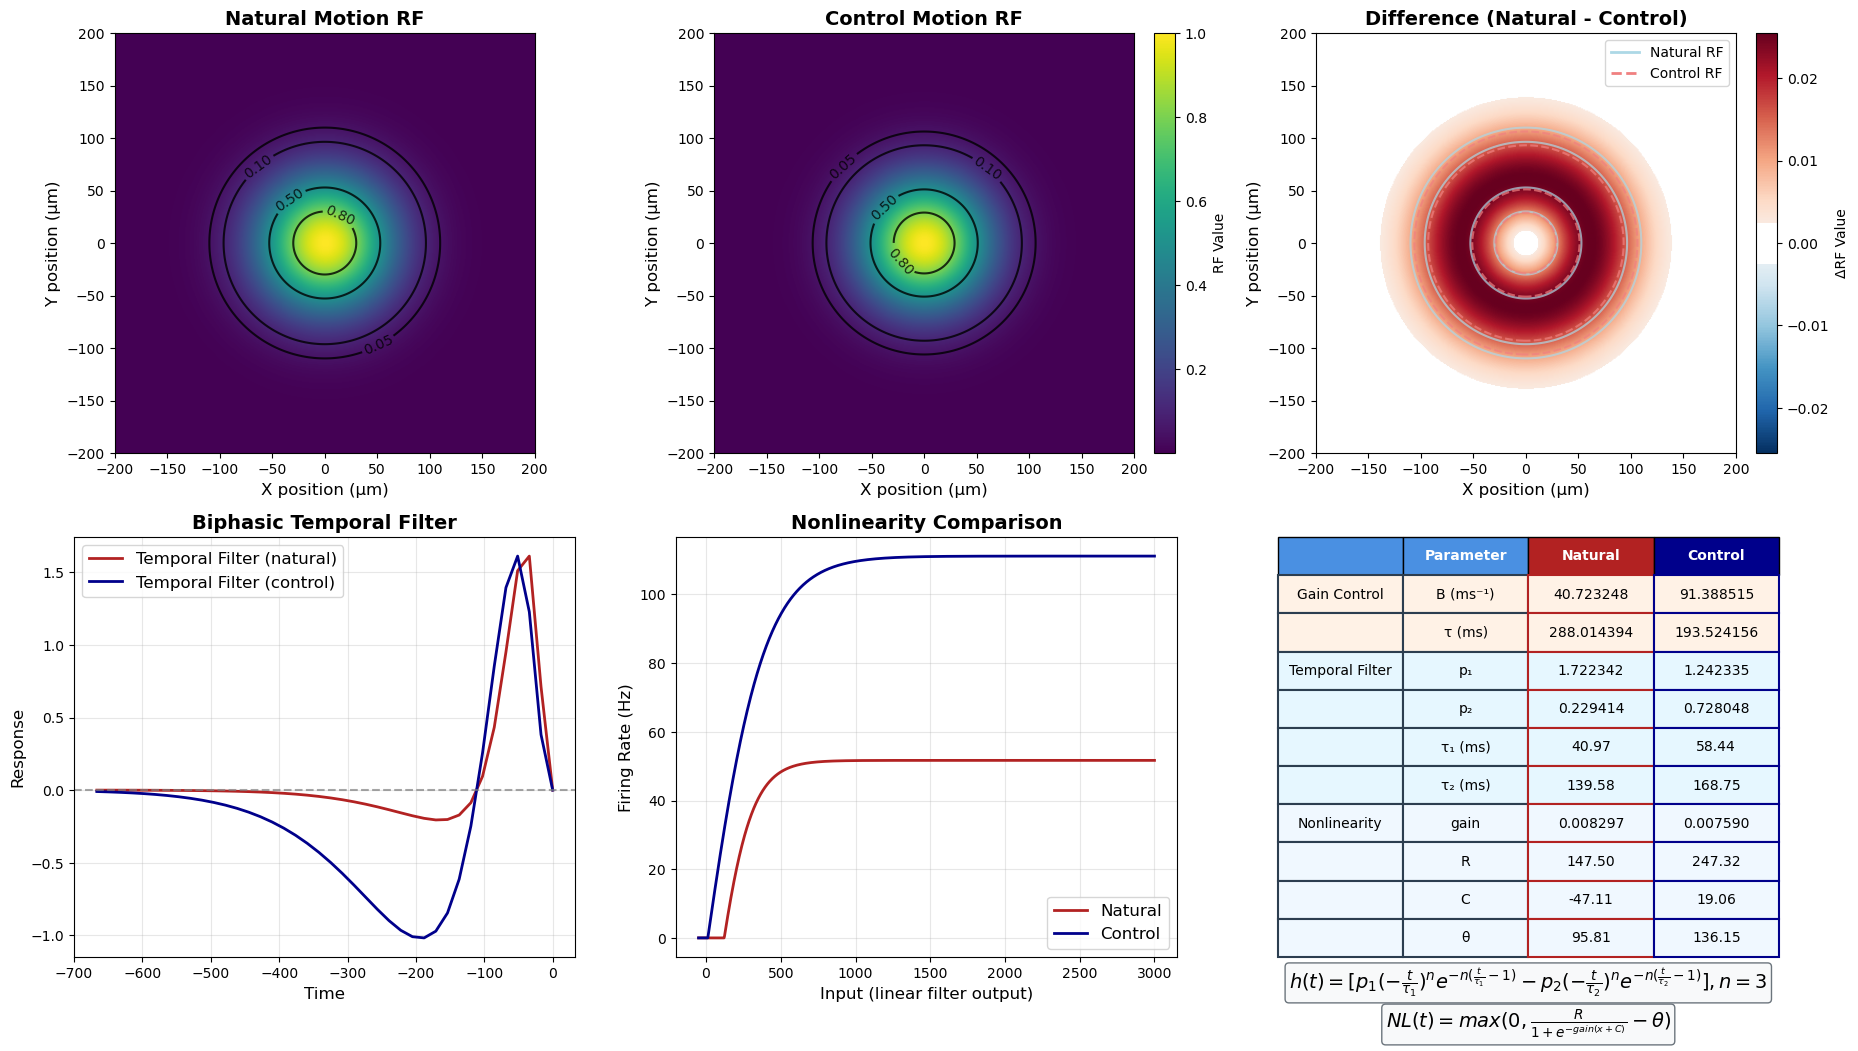

In [11]:

# Create a comprehensive figure with spatial filters in left column, temporal filter in top right, nonlinearity in lower right
fig = plt.figure(figsize=(22, 12))

# Define board size and range
board_size = 400
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
Xg, Yg = np.meshgrid(x_vals, y_vals)

# Set consistent color scale for RFs
vmin = min(np.nanmin(rfN), np.nanmin(rfC))
vmax = max(np.nanmax(rfN), np.nanmax(rfC))

# Natural RF (left column, top)
ax1 = fig.add_subplot(231)
im0 = ax1.imshow(rfN, origin='lower', extent=board_range*2, cmap='viridis', vmin=vmin, vmax=vmax)
cs0 = ax1.contour(Xg, Yg, rfN, levels=[0.05*np.nanmax(rfN), 0.1*np.nanmax(rfN), 0.5*np.nanmax(rfN), 0.8*np.nanmax(rfN)],
                  colors='k', linewidths=1.5, alpha=0.8)
ax1.clabel(cs0, inline=1, fmt='%.2f', fontsize=10)
ax1.set_title('Natural Motion RF', fontsize=14, fontweight='bold')
ax1.set_xlabel('X position (µm)', fontsize=12)
ax1.set_ylabel('Y position (µm)', fontsize=12)


# Control RF (left column, middle)
ax2 = fig.add_subplot(232)
im1 = ax2.imshow(rfC, origin='lower', extent=board_range*2, cmap='viridis', vmin=vmin, vmax=vmax)
cs1 = ax2.contour(Xg, Yg, rfC, levels=[0.05*np.nanmax(rfC), 0.1*np.nanmax(rfC), 0.5*np.nanmax(rfC), 0.8*np.nanmax(rfC)],
                  colors='k', linewidths=1.5, alpha=0.8)
ax2.clabel(cs1, inline=1, fmt='%.2f', fontsize=10)
ax2.set_title('Control Motion RF', fontsize=14, fontweight='bold')
ax2.set_xlabel('X position (µm)', fontsize=12)
ax2.set_ylabel('Y position (µm)', fontsize=12)
fig.colorbar(im1, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04, label='RF Value')

# Difference map (left column, bottom)
diff = rfN - rfC
diff_max = np.nanmax(np.abs(diff))

# Create custom colormap with white center
colors = plt.cm.RdBu_r(np.linspace(0, 1, 256))
mid_start = int(256 * (0.5 - 0.05))
mid_end = int(256 * (0.5 + 0.05))
colors[mid_start:mid_end] = [1, 1, 1, 1]
custom_cmap = ListedColormap(colors)

ax3 = fig.add_subplot(233)
im2 = ax3.imshow(diff, origin='lower', extent=board_range*2, cmap=custom_cmap, vmin=-diff_max, vmax=diff_max)

# Overlay contours
cs_n = ax3.contour(Xg, Yg, rfN, levels=[0.05*np.nanmax(rfN), 0.1*np.nanmax(rfN), 0.5*np.nanmax(rfN), 0.8*np.nanmax(rfN)],
                   colors='lightblue', linewidths=1.5, alpha=0.7, linestyles='-')
cs_c = ax3.contour(Xg, Yg, rfC, levels=[0.05*np.nanmax(rfC), 0.1*np.nanmax(rfC), 0.5*np.nanmax(rfC), 0.8*np.nanmax(rfC)],
                   colors='lightcoral', linewidths=1.5, alpha=0.7, linestyles='--')

ax3.set_title('Difference (Natural - Control)', fontsize=14, fontweight='bold')
ax3.set_xlabel('X position (µm)', fontsize=12)
ax3.set_ylabel('Y position (µm)', fontsize=12)
fig.colorbar(im2, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04, label='ΔRF Value')

# Legend for contours
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='lightblue', lw=2, label='Natural RF'),
                   Line2D([0], [0], color='lightcoral', lw=2, linestyle='--', label='Control RF')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Temporal filter subplot (top right)
ax4 = fig.add_subplot(234)
ax4.plot(t_temporal, temp_rf_n, label='Temporal Filter (natural)', color='firebrick', linewidth=2)
ax4.plot(t_temporal, temp_rf_c*tfratio, label='Temporal Filter (control)', color='darkblue', linewidth=2)
ax4.legend(fontsize=12)
ax4.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax4.grid(True, alpha=0.3)
ax4.set_title('Biphasic Temporal Filter', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylabel('Response', fontsize=12)
ax4.tick_params(axis='both', which='major', labelsize=10)

# Nonlinearity comparison (lower right)
tNN = np.linspace(-50, 3000, 1200)
tLNControl = apply_nonlinearity(apply_nonlinearity(tNN, method='sigmoid', gain=gain_c/tfratio, max_rate=max_rate_c, y=y_c*tfratio), method='threshold_linear', theta=theta_c)
tLNNatural = apply_nonlinearity(apply_nonlinearity(tNN, method='sigmoid', gain=gain_n, max_rate=max_rate_n, y=y_n), method='threshold_linear', theta=theta_n)

ax5 = fig.add_subplot(235)
ax5.plot(tNN, tLNNatural, 'firebrick', linewidth=2, label='Natural', color='firebrick')
ax5.plot(tNN, tLNControl, 'darkblue', linewidth=2, label='Control', color='darkblue')
ax5.set_xlabel('Input (linear filter output)', fontsize=12)
ax5.set_ylabel('Firing Rate (Hz)', fontsize=12)
ax5.set_title('Nonlinearity Comparison', fontsize=14, fontweight='bold')
ax5.legend(fontsize=12)
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='both', which='major', labelsize=10)

# Parameter comparison table (bottom right)

# 6th subplot: parameter comparison table
ax6 = fig.add_subplot(236)
ax6.axis('off')

# Build the table data, grouping by mechanism but only labeling each mechanism once
param_data = [
    ['',              'Parameter',      'Natural',                'Control'],
    ['Gain Control',   'B (ms⁻¹)',       f'{B_n*60000:.6f}',       f'{B_c*60000:.6f}'],
    ['',               'τ (ms)',         f'{tau_n*100/6:.6f}',     f'{tau_c*100/6:.6f}'],
    ['Temporal Filter','p₁',             f'{p1_n:.6f}',            f'{p1_c:.6f}'],
    ['',               'p₂',             f'{p2_n:.6f}',            f'{p2_c:.6f}'],
    ['',               'τ₁ (ms)',        f'{tau1_n:.2f}',          f'{tau1_c:.2f}'],
    ['',               'τ₂ (ms)',        f'{tau2_n:.2f}',          f'{tau2_c:.2f}'],
    ['Nonlinearity',    'gain',       f'{gain_n:.6f}',          f'{gain_c:.6f}'],
    ['',                   'R',  f'{max_rate_n:.2f}',      f'{max_rate_c:.2f}'],
    ['',                   'C',         f'{y_n:.2f}',             f'{y_c:.2f}'],
    ['',                   'θ',         f'{theta_n:.2f}',         f'{theta_c:.2f}'],
]
# Separate out headers and cell text
col_labels = param_data[0]
cell_text = param_data[1:]

# Create the table
table = ax6.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]  # Fixed: Changed tuple to list for bbox parameter
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Define colors for header and each mechanism block
colors = {
    'header': {
        '': '#4A90E2',      # blue header for first two columns
        'Parameter': '#4A90E2',
        'Natural': 'firebrick',      # firebrick for natural column
        'Control': 'darkblue'        # dark blue for control column
    },
    'Gain Control':   '#FFF2E6',
    'Temporal Filter':'#E6F7FF',
    'Nonlinearity':    '#F0F8FF'
}

# Apply background and edge styling
for (i, j), cell in table.get_celld().items():
    if i == 0:
        # Header row coloring
        label = col_labels[j]
        cell.set_facecolor(colors['header'][label])
        cell.set_text_props(weight='bold', color='white')
    else:
        # Determine mechanism for this row (look up first non-empty mech above)
        mech = cell_text[i-1][0] or cell_text[i-2][0]
        # Fixed: Handle empty string case to prevent KeyError
        if mech == '':
            # Find the most recent non-empty mechanism
            for k in range(i-1, -1, -1):
                if cell_text[k][0] != '':
                    mech = cell_text[k][0]
                    break
        cell.set_facecolor(colors[mech])
        
        # Add colored borders for Natural and Control columns
        if j == 2:  # Natural column
            cell.set_edgecolor('firebrick')
            cell.set_linewidth(1.5)
        elif j == 3:  # Control column
            cell.set_edgecolor('darkblue')
            cell.set_linewidth(1.5)
        else:
            cell.set_edgecolor('#2C3E50')
            cell.set_linewidth(1.5)

eqn = r"$h(t) = [p_1(-\frac{t}{\tau_1})^n e^{-n(\frac{t}{\tau_1}-1)} - p_2(-\frac{t}{\tau_2})^n e^{-n(\frac{t}{\tau_2}-1)}], n=3$"
eqn2 = r"$NL(t) = max(0, \frac{R}{1+e^{-gain(x+C)}} - \theta)$"
ax6.text(
    0.5, -0.1, eqn,
    transform=ax6.transAxes,
    fontsize=14,
    ha='center',
    va='bottom',
    style='italic',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='#F8F9FA', edgecolor='#6C757D')
)
ax6.text(
    0.5, -0.2, eqn2,
    transform=ax6.transAxes,
    fontsize=14,
    ha='center',
    va='bottom',
    style='italic',
    bbox=dict(boxstyle='round,pad=0.2', facecolor='#F8F9FA', edgecolor='#6C757D')
)

# Results

In [12]:
spike_trains_n = []
spike_trains_nemd = []
for trial_idx, spikes in enumerate(spike_indices_n):
    st_n = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=1550)
    st_narray = spikes.flatten() / 10
    spike_trains_n.append(st_n)
    spike_trains_nemd.append(st_narray)

spike_trains_c = []
spike_trains_cemd = []
for trial_idx, spikes in enumerate(spike_indices_c):
    st_c = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=1550)
    st_carray = spikes.flatten() / 10
    spike_trains_c.append(st_c)
    spike_trains_cemd.append(st_carray)

In [16]:
# Generate model spike trains with signal comparison for NATURAL stimuli
spike_trainGCvpfit_n = []
spike_trains_modelvp_n = []         
reference_spike_trains_n = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1]

# Store signals for comparison (natural)
signals_before_gain_n = []
signals_after_gain_n = []
gain_values_n = []

with h5py.File('results/stimulic2_nV3.h5', 'r') as f:
    movies_n = f['stimuli']
    movies_trianc_n = [movies_n[i] for i in range(679) if i % 2 == 1]
    
    for i, stimuli in enumerate(movies_trianc_n):
        LoutGCvpfit = linear_filter(spatial_filterV3_n, stimuli, temporal_filter_n)
        
        # Store signal before gain control
        signals_before_gain_n.append(LoutGCvpfit.copy())
        
        # Apply gain control
        LoutGCvpfit, g = gain_control(LoutGCvpfit, B_n, tau_n)
        
        # Store signal after gain control and gain values
        signals_after_gain_n.append(LoutGCvpfit.copy())
        gain_values_n.append(g.copy())
        
        LNoutGCvpfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCvpfit, 'sigmoid', gain=gain_n, max_rate=max_rate_n, y=y_n),
            method='threshold_linear', theta=theta_n)
        spikingindx = resample_and_generate_spikes(LNoutGCvpfit, time_bin)
        st_model = np.array(np.where(spikingindx > 0)[0]).flatten() / 54 * 10
        st_modelvp = SpikeTrain(np.array(np.where(spikingindx > 0)[0]).flatten() / 54 * 10 * ms,t_stop=1550)
        spike_trainGCvpfit_n.append(st_model)
        spike_trains_modelvp_n.append(st_modelvp)

# Generate model spike trains with signal comparison for CONTROL stimuli
spike_trainGCvpfit_c = []
spike_trains_modelvp_c = []         
reference_spike_trains_c = [spike_trains_c[i] for i in range(len(spike_trains_c)) if i % 2 == 1]

# Store signals for comparison (control)
signals_before_gain_c = []
signals_after_gain_c = []
gain_values_c = []

with h5py.File('results/stimulic2_cV3.h5', 'r') as f:
    movies_c = f['stimuli']
    movies_trianc_c = [movies_c[i] for i in range(682) if i % 2 == 1]
    
    for i, stimuli in enumerate(movies_trianc_c):
        LoutGCvpfit = linear_filter(spatial_filterV3_c, stimuli, temporal_filter_c)
        
        # Store signal before gain control
        signals_before_gain_c.append(LoutGCvpfit.copy())
        
        # Apply gain control
        LoutGCvpfit, g = gain_control(LoutGCvpfit, B_c, tau_c)
        
        # Store signal after gain control and gain values
        signals_after_gain_c.append(LoutGCvpfit.copy())
        gain_values_c.append(g.copy())
        
        LNoutGCvpfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCvpfit, 'sigmoid', gain=gain_c, max_rate=max_rate_c, y=y_c),
            method='threshold_linear', theta=theta_c)
        spikingindx = resample_and_generate_spikes(LNoutGCvpfit, time_bin)
        st_model = np.array(np.where(spikingindx > 0)[0]).flatten() / 54 * 10
        st_modelvp = SpikeTrain(np.array(np.where(spikingindx > 0)[0]).flatten() / 54 * 10 * ms,t_stop=1550)
        spike_trainGCvpfit_c.append(st_model)
        spike_trains_modelvp_c.append(st_modelvp)






In [17]:
n_seeds  = 100
seeds_min = 1
seeds_max = n_seeds

NCompareVp_c = np.full((n_seeds,7), np.nan)
NCompareEmd_c = np.full((n_seeds,7), np.nan)
Normalizedrateidx_c = np.full((n_seeds,7), np.nan)

spike_indices_c_Eval = [spike_indices_c[i] for i in range(len(spike_indices_c)) if i % 2 == 1]
motion_seed_c_Eval = np.array([motion_seed_c[i] for i in range(len(motion_seed_c)) if i % 2 == 1])
cells_c_Eval = np.array([cells_c[i] for i in range(len(cells_c)) if i % 2 == 1])
for seeds in range(seeds_min,seeds_max+1):
    group_c = np.where(motion_seed_c_Eval == seeds)[0]
    cell_pos_c = cells_c_Eval[group_c]
    for x in range(len(cell_pos_c)):
        st_c = SpikeTrain(spike_indices_c_Eval[group_c[x]].flatten() / 10 * ms, t_stop=1550)
        st_cmodel = spike_trains_modelvp_c[group_c[x]]
        st_carray = spike_indices_c_Eval[group_c[x]].flatten() / 10
        st_carraymodel = spike_trainGCvpfit_c[group_c[x]]
        if st_carraymodel.shape[0] == 0:
            st_carraymodel = np.array([0., 0.])
        if st_carray.shape[0] == 0:
            st_carray = np.array([0., 0.])
        NCompareVp_c[seeds-seeds_min][cell_pos_c[x]-1] = victor_purpura_distance([st_c, st_cmodel],q)[0,1]
        NCompareEmd_c[seeds-seeds_min][cell_pos_c[x]-1] = wasserstein_distance(st_carray, st_carraymodel)
        Normalizedrateidx_c[seeds-seeds_min][cell_pos_c[x]-1] = (len(st_carray)+(len(st_carraymodel))) 
NCompareVpNormalized_c = NCompareVp_c / Normalizedrateidx_c
NCompareEmdNormalized_c = NCompareEmd_c / Normalizedrateidx_c


NCompareVp_n = np.full((n_seeds,7), np.nan)
NCompareEmd_n = np.full((n_seeds,7), np.nan)
Normalizedrateidx_n = np.full((n_seeds,7), np.nan)

spike_indices_n_Eval = [spike_indices_n[i] for i in range(len(spike_indices_n)) if i % 2 == 1]
motion_seed_n_Eval = np.array([motion_seed_n[i] for i in range(len(motion_seed_n)) if i % 2 == 1])
cells_n_Eval = np.array([cells_n[i] for i in range(len(cells_n)) if i % 2 == 1])
for seeds in range(seeds_min,seeds_max+1):
    group_n = np.where(motion_seed_n_Eval == seeds)[0]
    cell_pos_n = cells_n_Eval[group_n]
    for x in range(len(cell_pos_n)):
        st_n = SpikeTrain(spike_indices_n_Eval[group_n[x]].flatten() / 10 * ms, t_stop=1550)
        st_nmodel = spike_trains_modelvp_n[group_n[x]]
        st_narray = spike_indices_n_Eval[group_n[x]].flatten() / 10
        st_narraymodel = spike_trainGCvpfit_n[group_n[x]]
        if st_narraymodel.shape[0] == 0:
            st_narraymodel = np.array([0., 0.])
        if st_narray.shape[0] == 0:
            st_narray = np.array([0., 0.])
        NCompareVp_n[seeds-seeds_min][cell_pos_n[x]-1] = victor_purpura_distance([st_n, st_nmodel],q)[0,1]
        NCompareEmd_n[seeds-seeds_min][cell_pos_n[x]-1] = wasserstein_distance(st_narray, st_narraymodel)
        Normalizedrateidx_n[seeds-seeds_min][cell_pos_n[x]-1] = (len(st_narray)+(len(st_narraymodel))) 
NCompareVpNormalized_n = NCompareVp_n / Normalizedrateidx_n
NCompareEmdNormalized_n = NCompareEmd_n / Normalizedrateidx_n




C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


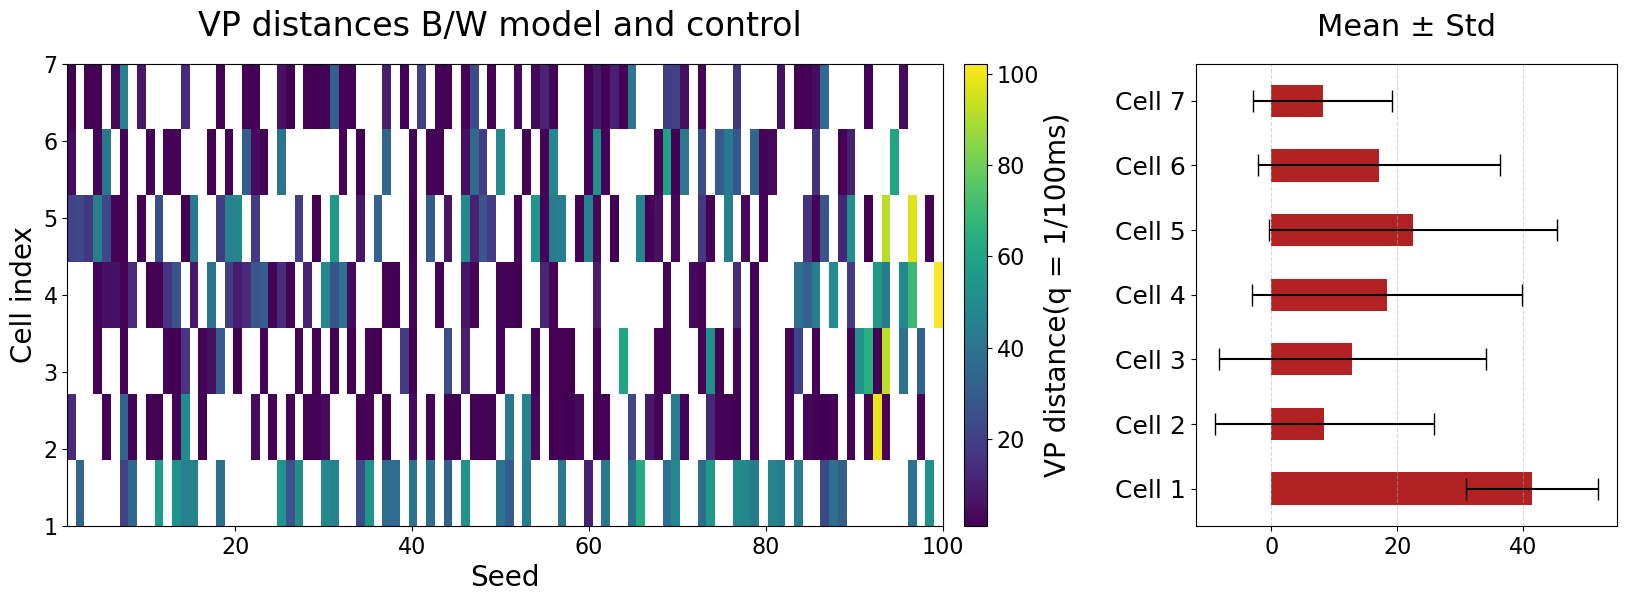

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


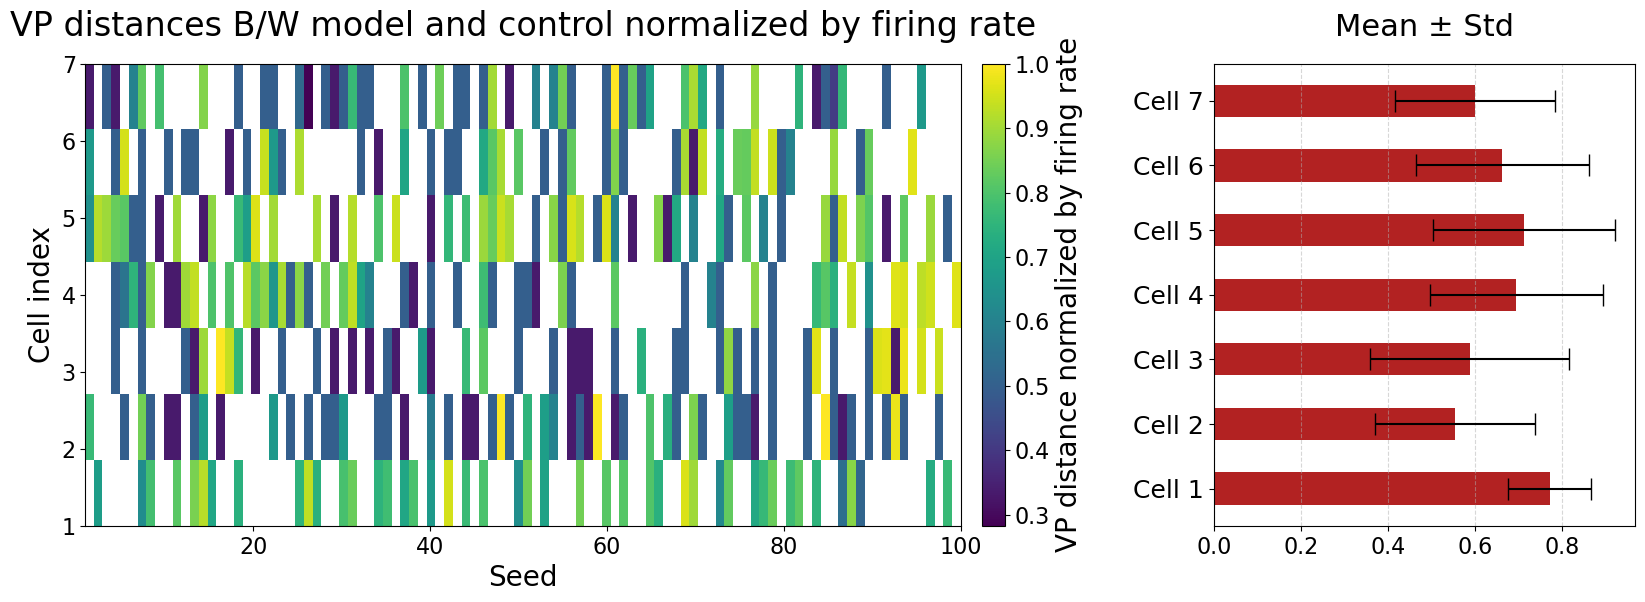

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


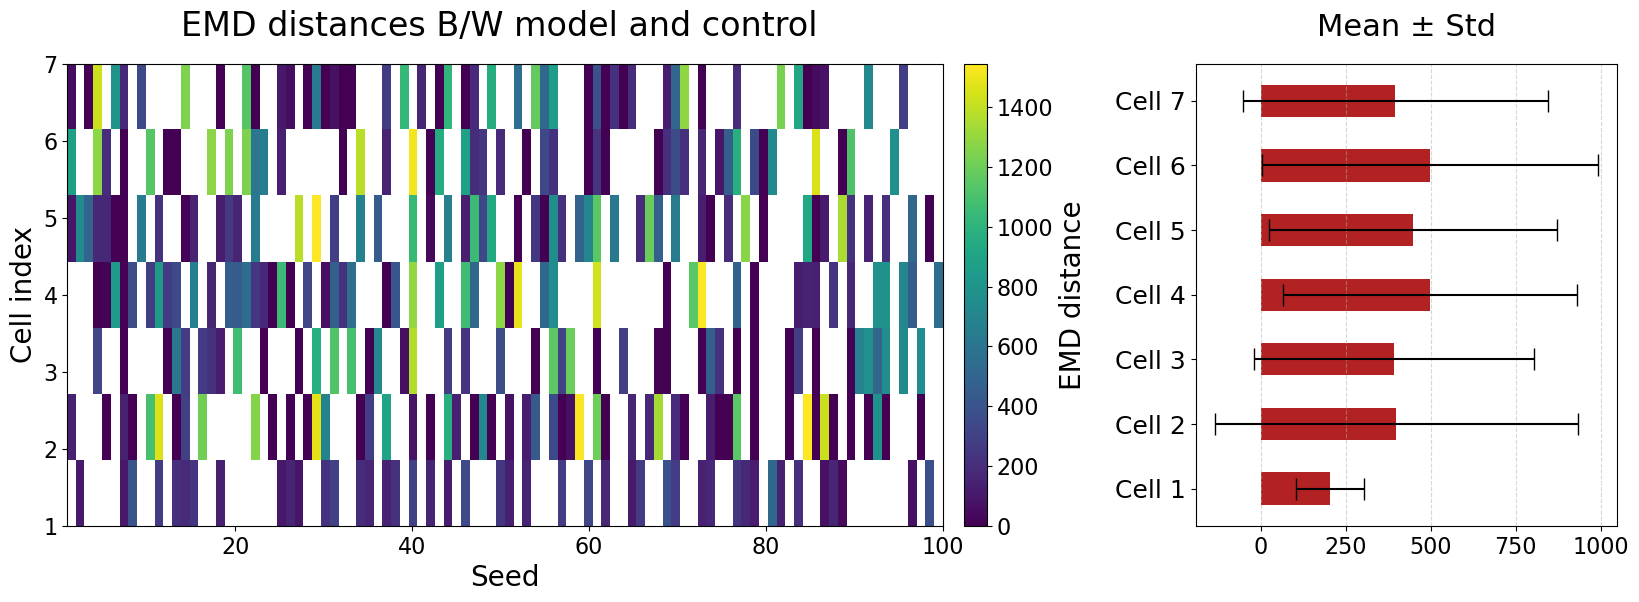

In [18]:
plot_distance_bar(NCompareVp_n, seeds_min, seeds_max,'VP distance(q = 1/100ms)', 'VP distances B/W model and control ')
plot_distance_bar(NCompareVpNormalized_n, seeds_min, seeds_max,'VP distance normalized by firing rate', 'VP distances B/W model and control normalized by firing rate')
plot_distance_bar(NCompareEmd_n, seeds_min, seeds_max,'EMD distance', 'EMD distances B/W model and control ')

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


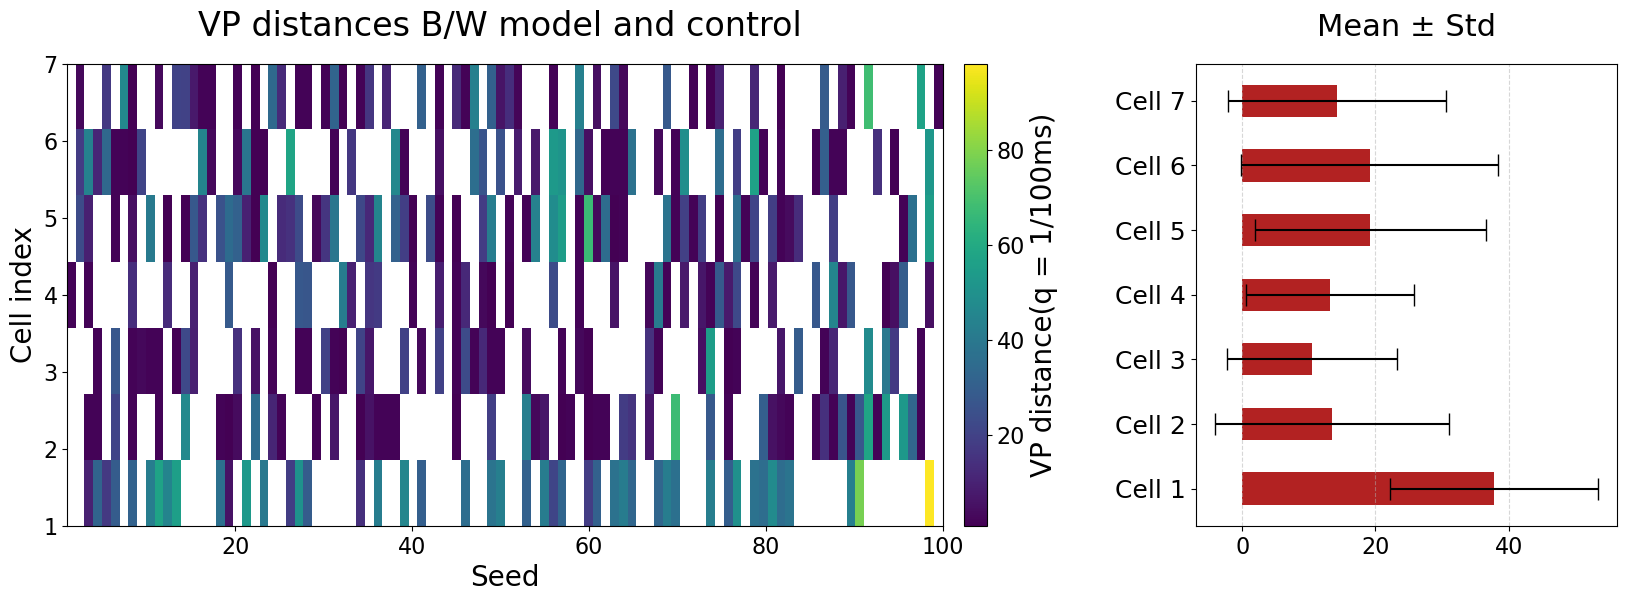

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


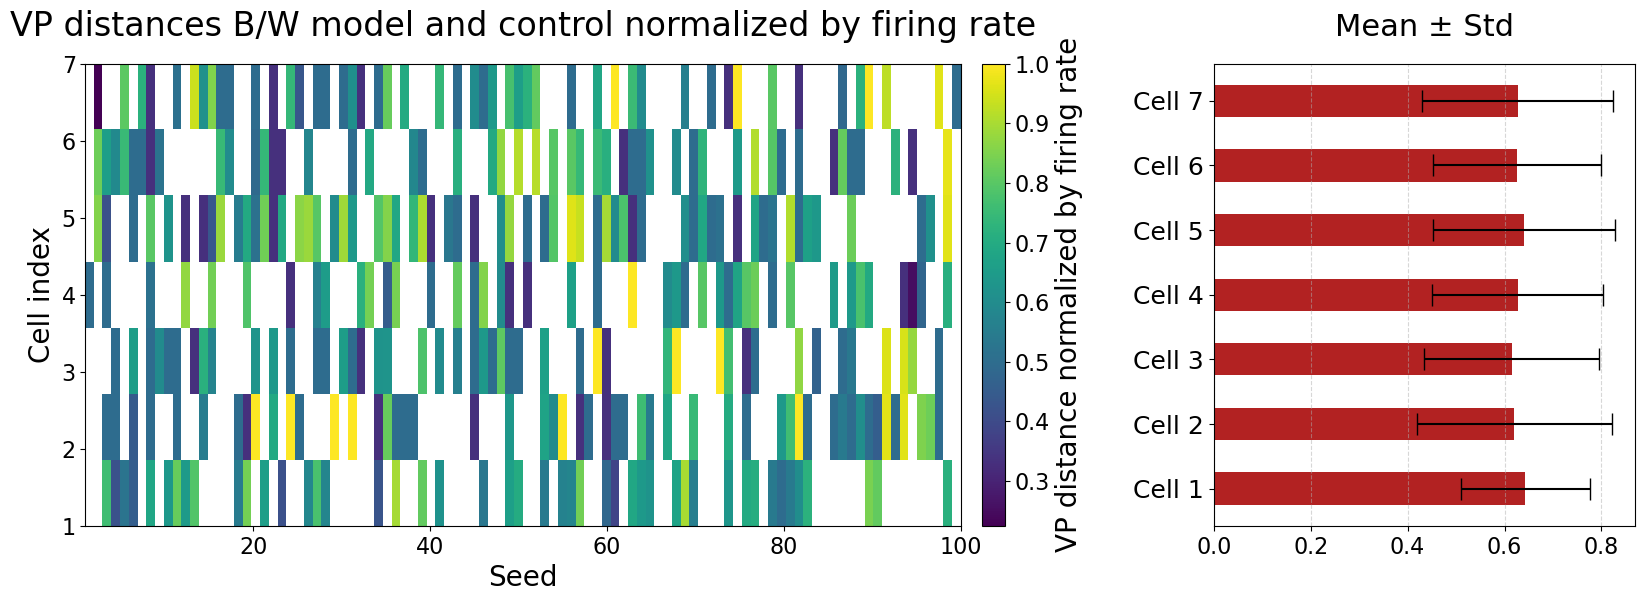

C:\Users\Komeijiiiii\AppData\Local\Temp\ipykernel_35884\3980009329.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 15)


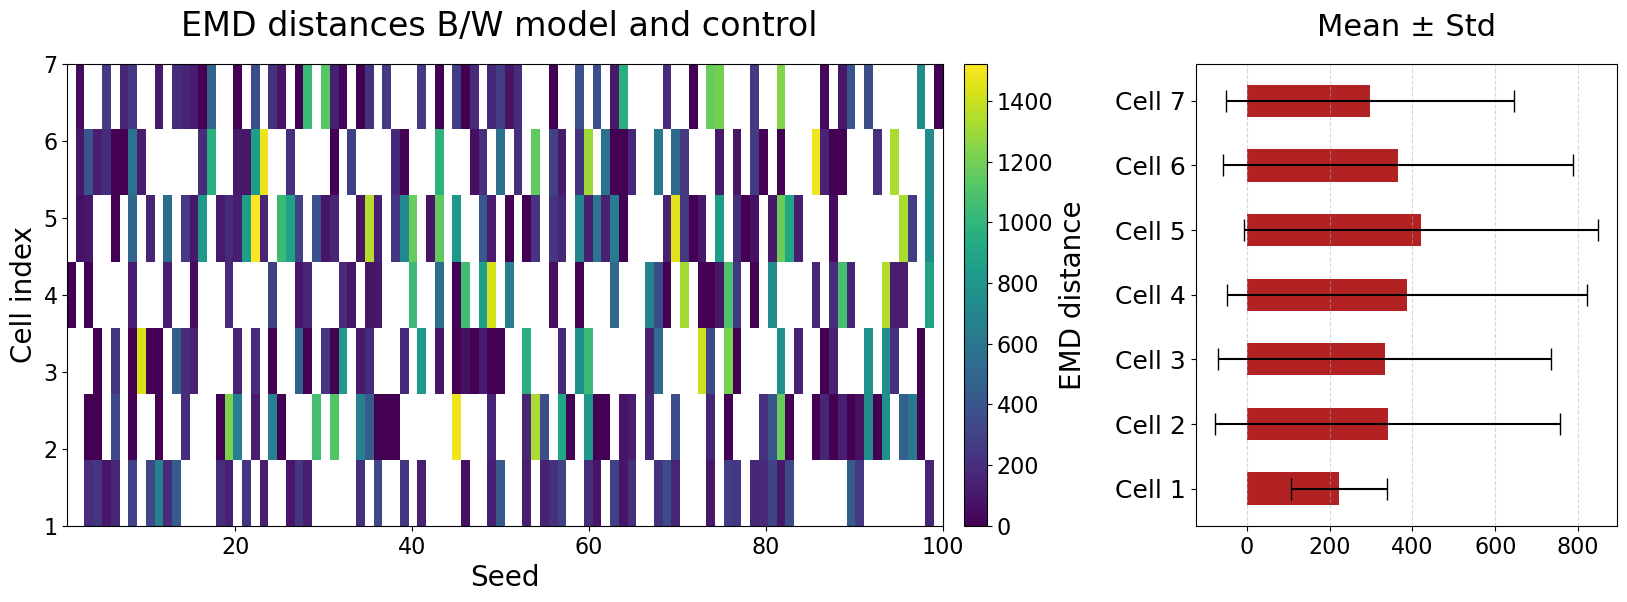

In [19]:
plot_distance_bar(NCompareVp_c, seeds_min, seeds_max,'VP distance(q = 1/100ms)', 'VP distances B/W model and control ')
plot_distance_bar(NCompareVpNormalized_c, seeds_min, seeds_max,'VP distance normalized by firing rate', 'VP distances B/W model and control normalized by firing rate')
plot_distance_bar(NCompareEmd_c, seeds_min, seeds_max,'EMD distance', 'EMD distances B/W model and control ')

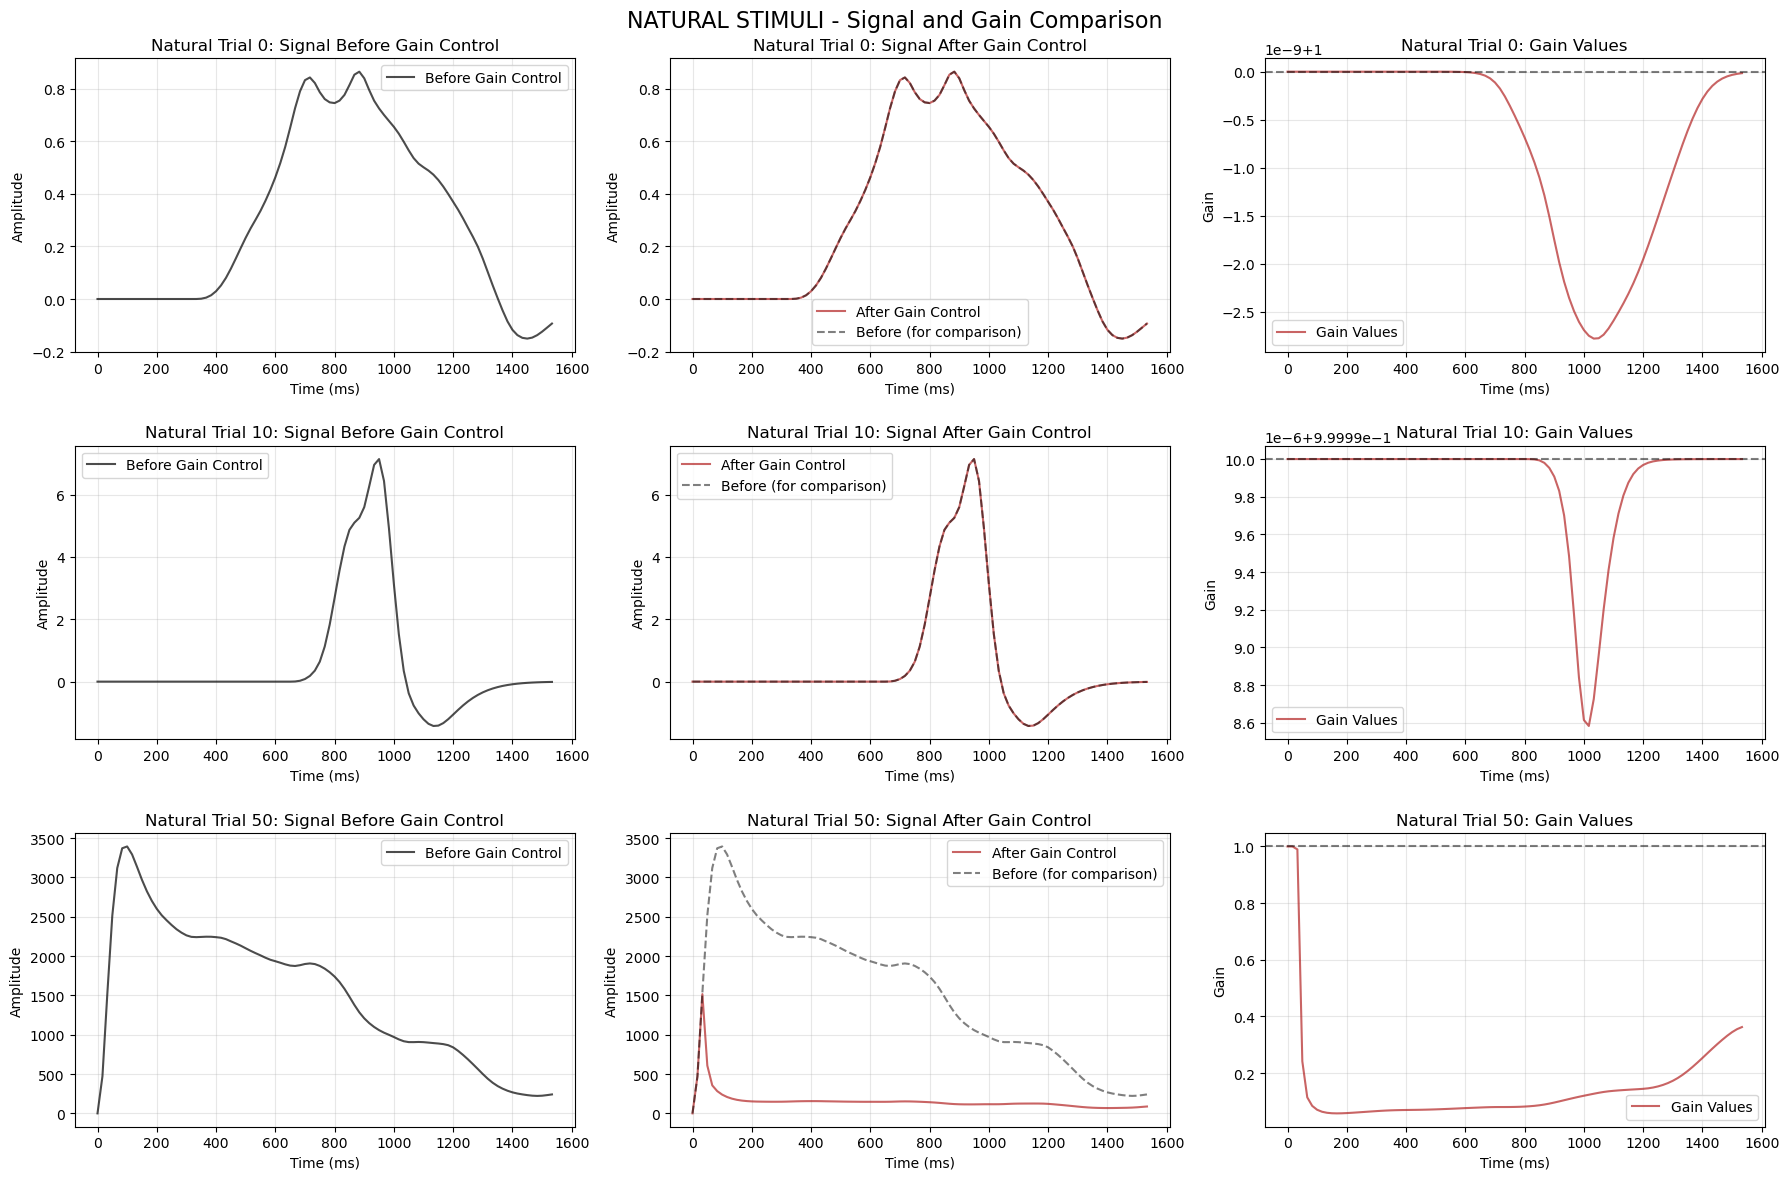

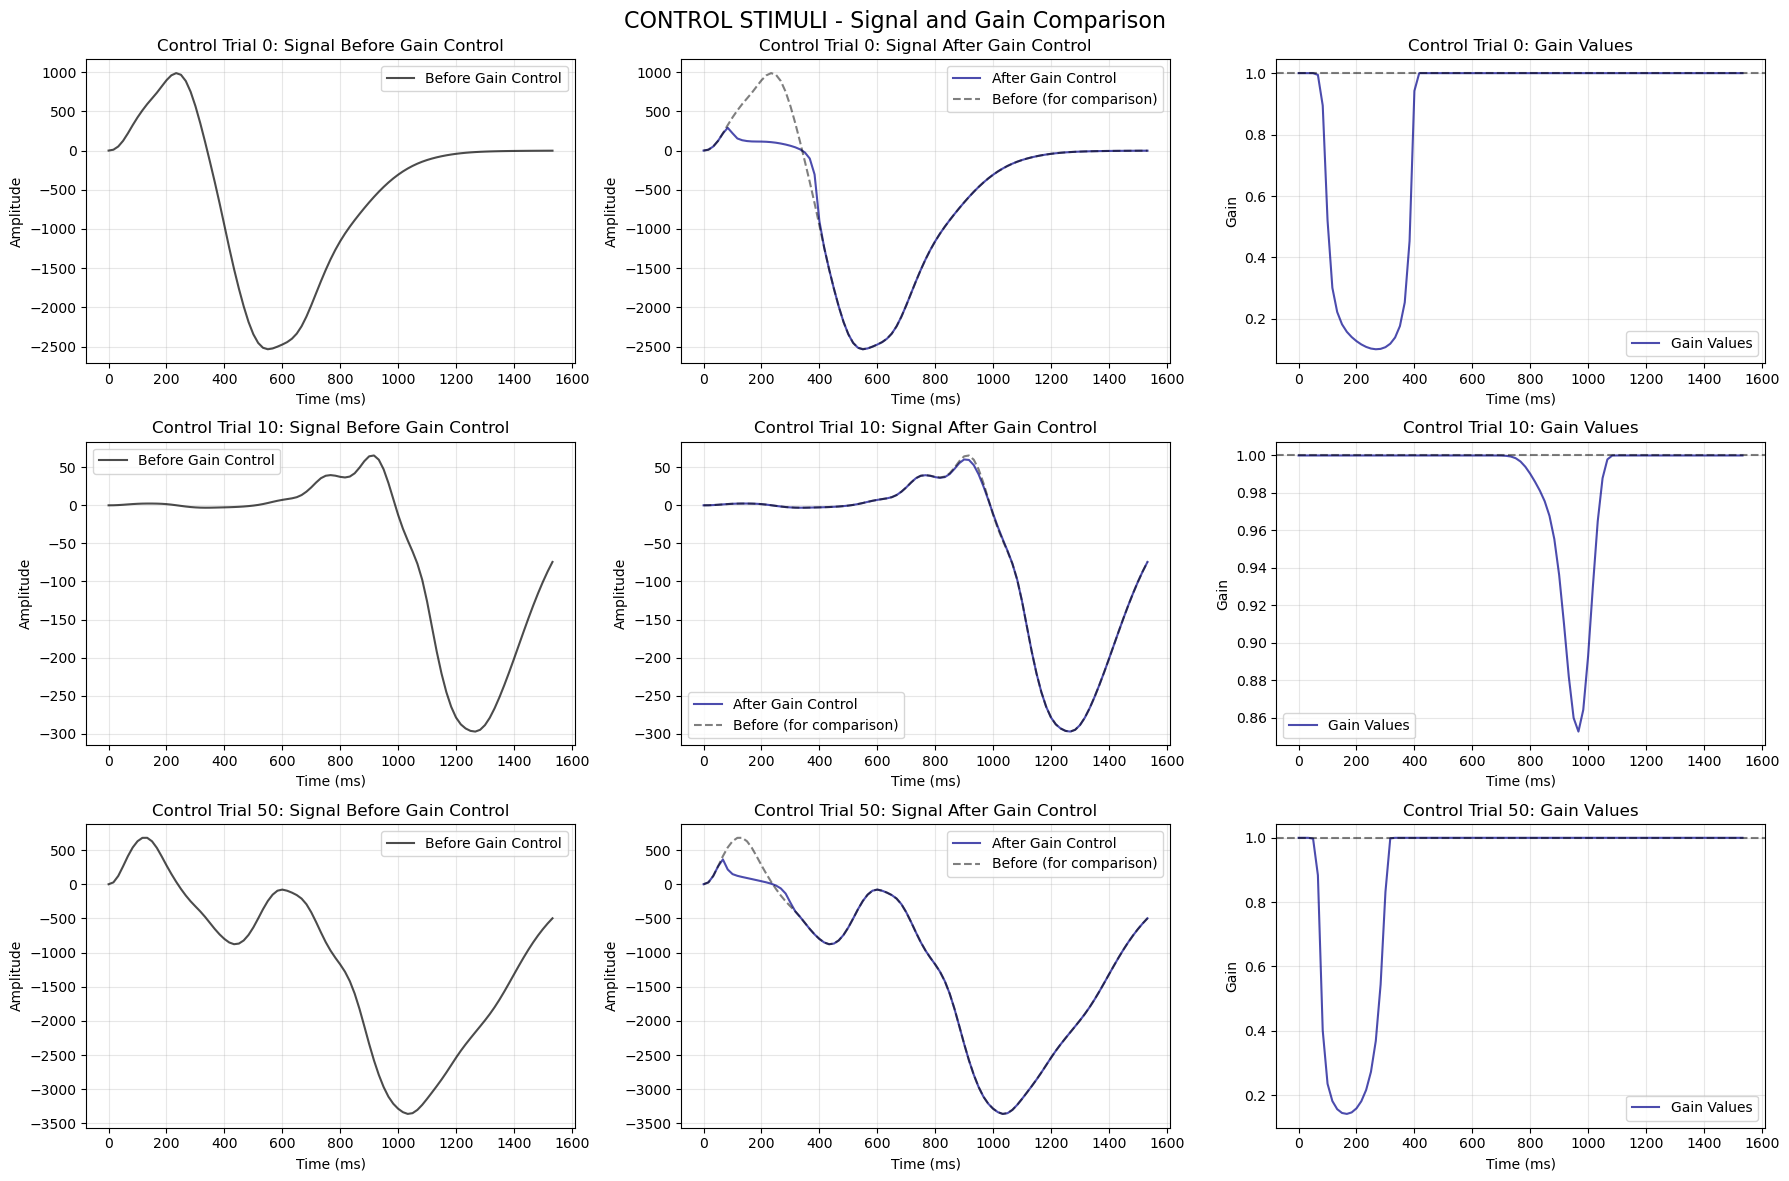

=== NATURAL STIMULI - SIGNAL COMPARISON STATISTICS ===

Trial 0:
  Before gain control - Mean: 0.2942, Std: 0.3306, Max: 0.8644
  After gain control  - Mean: 0.2942, Std: 0.3306, Max: 0.8644
  Gain values         - Mean: 1.0000, Min: 1.0000, Max: 1.0000
  Signal ratio (after/before): 1.0000

Trial 10:
  Before gain control - Mean: 0.6064, Std: 1.9431, Max: 7.1432
  After gain control  - Mean: 0.6064, Std: 1.9431, Max: 7.1432
  Gain values         - Mean: 1.0000, Min: 1.0000, Max: 1.0000
  Signal ratio (after/before): 1.0000

Trial 50:
  Before gain control - Mean: 1511.8191, Std: 876.5619, Max: 3394.6692
  After gain control  - Mean: 155.5552, Std: 160.3719, Max: 1516.8555
  Gain values         - Mean: 0.1515, Min: 0.0575, Max: 1.0000
  Signal ratio (after/before): 0.1029

Natural VP distance: 6.945173605885796
=== CONTROL STIMULI - SIGNAL COMPARISON STATISTICS ===

Trial 0:
  Before gain control - Mean: -527.6829, Std: 995.3760, Max: 987.3818
  After gain control  - Mean: -611.9951, S

In [20]:

# Create subplots for signal comparison and gain values
trial_indices = [0, 10, 50]  # Plot trials 0, 10, and 50

# NATURAL STIMULI - Combined signal and gain comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for idx, trial in enumerate(trial_indices):
    # Create time axis in milliseconds (frames * 1000/60)
    time_ms = np.arange(len(signals_before_gain_n[trial])) * 1000 / 60
    
    # Signal before gain control
    axes[idx, 0].plot(time_ms, signals_before_gain_n[trial], 'k-', alpha=0.7, label='Before Gain Control')
    axes[idx, 0].set_title(f'Natural Trial {trial}: Signal Before Gain Control')
    axes[idx, 0].set_xlabel('Time (ms)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Signal after gain control
    axes[idx, 1].plot(time_ms, signals_after_gain_n[trial], 'firebrick', alpha=0.7, label='After Gain Control')
    axes[idx, 1].plot(time_ms, signals_before_gain_n[trial], 'k--', alpha=0.5, label='Before (for comparison)')
    axes[idx, 1].set_title(f'Natural Trial {trial}: Signal After Gain Control')
    axes[idx, 1].set_xlabel('Time (ms)')
    axes[idx, 1].set_ylabel('Amplitude')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Gain values
    axes[idx, 2].plot(time_ms, gain_values_n[trial], 'firebrick', alpha=0.7, label='Gain Values')
    axes[idx, 2].set_title(f'Natural Trial {trial}: Gain Values')
    axes[idx, 2].set_xlabel('Time (ms)')
    axes[idx, 2].set_ylabel('Gain')
    axes[idx, 2].legend()
    axes[idx, 2].grid(True, alpha=0.3)
    axes[idx, 2].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Gain = 1')

plt.suptitle('NATURAL STIMULI - Signal and Gain Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# CONTROL STIMULI - Combined signal and gain comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for idx, trial in enumerate(trial_indices):
    # Create time axis in milliseconds (frames * 1000/60)
    time_ms = np.arange(len(signals_before_gain_c[trial])) * 1000 / 60
    
    # Signal before gain control
    axes[idx, 0].plot(time_ms, signals_before_gain_c[trial], 'k-', alpha=0.7, label='Before Gain Control')
    axes[idx, 0].set_title(f'Control Trial {trial}: Signal Before Gain Control')
    axes[idx, 0].set_xlabel('Time (ms)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Signal after gain control
    axes[idx, 1].plot(time_ms, signals_after_gain_c[trial], 'darkblue', alpha=0.7, label='After Gain Control')
    axes[idx, 1].plot(time_ms, signals_before_gain_c[trial], 'k--', alpha=0.5, label='Before (for comparison)')
    axes[idx, 1].set_title(f'Control Trial {trial}: Signal After Gain Control')
    axes[idx, 1].set_xlabel('Time (ms)')
    axes[idx, 1].set_ylabel('Amplitude')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Gain values
    axes[idx, 2].plot(time_ms, gain_values_c[trial], 'darkblue', alpha=0.7, label='Gain Values')
    axes[idx, 2].set_title(f'Control Trial {trial}: Gain Values')
    axes[idx, 2].set_xlabel('Time (ms)')
    axes[idx, 2].set_ylabel('Gain')
    axes[idx, 2].legend()
    axes[idx, 2].grid(True, alpha=0.3)
    axes[idx, 2].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Gain = 1')

plt.suptitle('CONTROL STIMULI - Signal and Gain Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# Statistical comparison for NATURAL stimuli
print("=== NATURAL STIMULI - SIGNAL COMPARISON STATISTICS ===")
for trial in trial_indices:
    before = signals_before_gain_n[trial]
    after = signals_after_gain_n[trial]
    gain = gain_values_n[trial]
    
    print(f"\nTrial {trial}:")
    print(f"  Before gain control - Mean: {np.mean(before):.4f}, Std: {np.std(before):.4f}, Max: {np.max(before):.4f}")
    print(f"  After gain control  - Mean: {np.mean(after):.4f}, Std: {np.std(after):.4f}, Max: {np.max(after):.4f}")
    print(f"  Gain values         - Mean: {np.mean(gain):.4f}, Min: {np.min(gain):.4f}, Max: {np.max(gain):.4f}")
    print(f"  Signal ratio (after/before): {np.mean(np.abs(after))/np.mean(np.abs(before)):.4f}")

spike_distances_vp_n = np.zeros(886)
for i in range(len(spike_trains_modelvp_n)):
    spike_distances_vp_n[i] = victor_purpura_distance([spike_trains_modelvp_n[i], reference_spike_trains_n[i]],q)[0,1]

score_n = np.nanmean(spike_distances_vp_n)
print(f"\nNatural VP distance: {score_n}")

# Statistical comparison for CONTROL stimuli
print("=== CONTROL STIMULI - SIGNAL COMPARISON STATISTICS ===")
for trial in trial_indices:
    before = signals_before_gain_c[trial]
    after = signals_after_gain_c[trial]
    gain = gain_values_c[trial]
    
    print(f"\nTrial {trial}:")
    print(f"  Before gain control - Mean: {np.mean(before):.4f}, Std: {np.std(before):.4f}, Max: {np.max(before):.4f}")
    print(f"  After gain control  - Mean: {np.mean(after):.4f}, Std: {np.std(after):.4f}, Max: {np.max(after):.4f}")
    print(f"  Gain values         - Mean: {np.mean(gain):.4f}, Min: {np.min(gain):.4f}, Max: {np.max(gain):.4f}")
    print(f"  Signal ratio (after/before): {np.mean(np.abs(after))/np.mean(np.abs(before)):.4f}")

spike_distances_vp_c = np.zeros(885)
for i in range(len(spike_trains_modelvp_c)):
    spike_distances_vp_c[i] = victor_purpura_distance([spike_trains_modelvp_c[i], reference_spike_trains_c[i]],q)[0,1]

score_c = np.nanmean(spike_distances_vp_c)
print(f"\nControl VP distance: {score_c}")


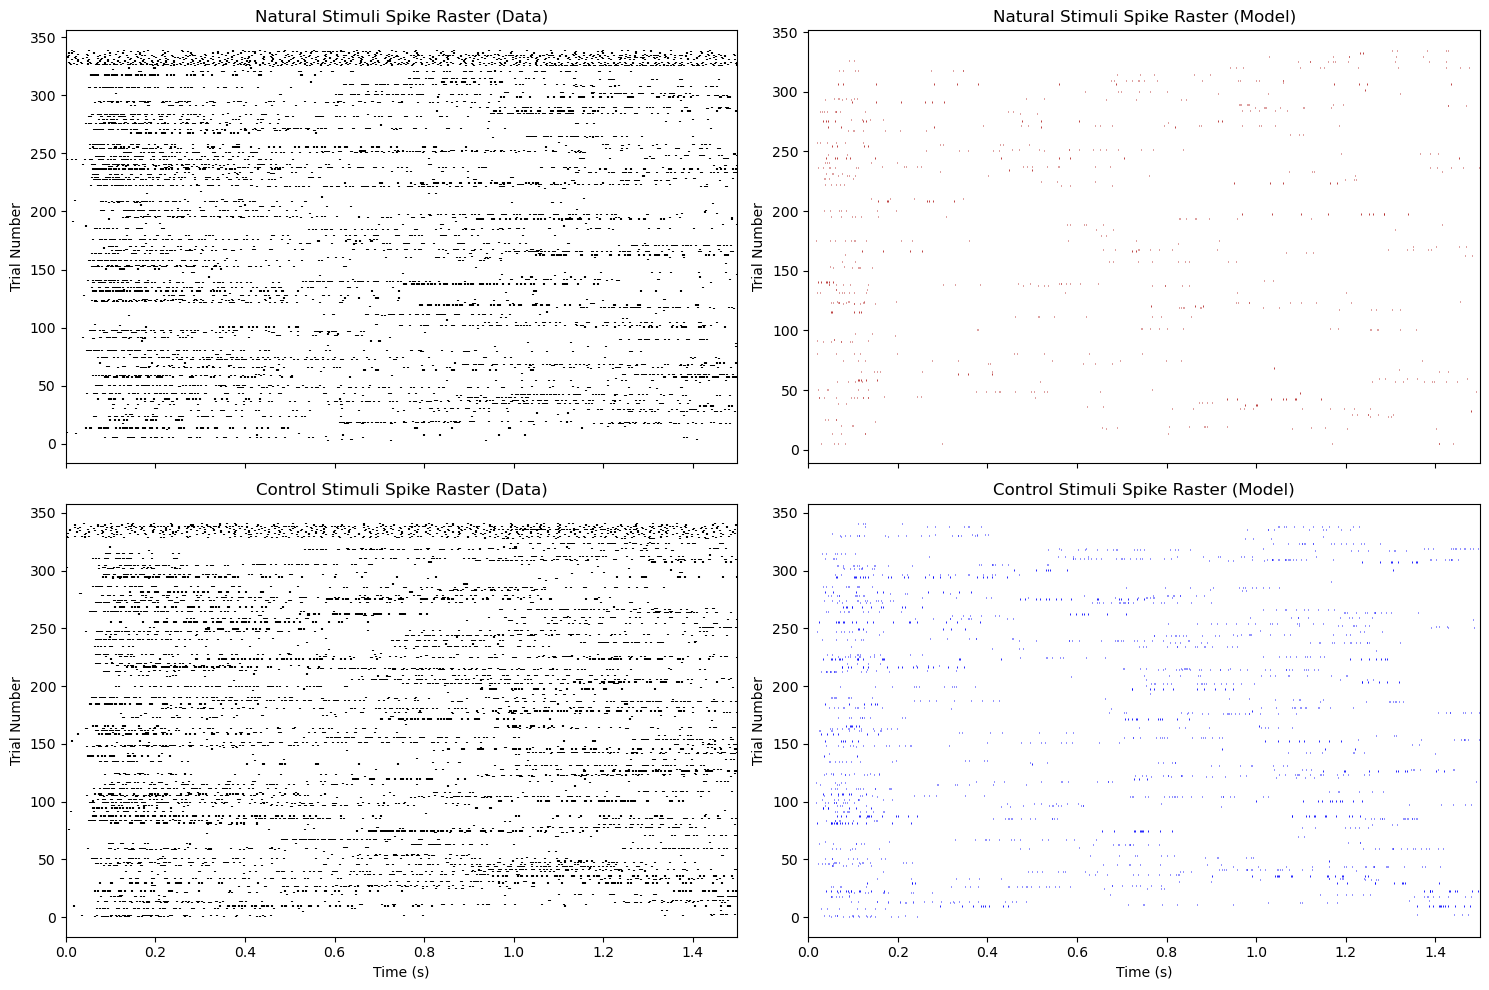

In [21]:
# Create subplots for both natural and control stimuli
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Natural stimuli plots
num_trials_n = len(spike_indices_n)
spikes_n = []
spikes_nmodel = []
spike_countsn = []
spike_countsnmodel = []

# Plot natural stimuli data
for spike_idx_n in range(int(num_trials_n/2)):
    spikes_in_trial = np.array(spike_indices_n[2*spike_idx_n+1]) / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    spike_countsn.append(spikes_in_trial.shape[0])
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=1.5)

# Plot natural stimuli model
for spike_idx_n in range(int(num_trials_n/2)):
    spikes_in_trial = np.array(spike_trainGCvpfit_n[spike_idx_n]) / 1000
    spikes_nmodel.extend(spikes_in_trial)
    spike_countsnmodel.append(spikes_in_trial.shape[0])
    ax2.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=0.6)

# Control stimuli plots
num_trials_c = len(spike_indices_c)
spikes_c = []
spikes_cmodel = []
spike_countsc = []
spike_countscmodel = []

# Plot control stimuli data
for spike_idx_c in range(int(num_trials_c/2)):
    spikes_in_trial = np.array(spike_indices_c[2*spike_idx_c+1]) / 10000 - delay
    spikes_c.extend(spikes_in_trial)
    spike_countsc.append(spikes_in_trial.shape[0])
    ax3.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'k', linewidth=1.5)

# Plot control stimuli model
for spike_idx_c in range(int(num_trials_c/2)):
    spikes_in_trial = np.array(spike_trainGCvpfit_c[spike_idx_c]) / 1000
    spikes_cmodel.extend(spikes_in_trial)
    spike_countscmodel.append(spikes_in_trial.shape[0])
    ax4.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'blue', linewidth=0.6)

# Set labels and titles
ax1.set_ylabel('Trial Number')
ax1.set_title('Natural Stimuli Spike Raster (Data)')
ax1.set_xlim(0, 1.5)

ax2.set_ylabel('Trial Number')
ax2.set_title('Natural Stimuli Spike Raster (Model)')
ax2.set_xlim(0, 1.5)

ax3.set_ylabel('Trial Number')
ax3.set_xlabel('Time (s)')
ax3.set_title('Control Stimuli Spike Raster (Data)')
ax3.set_xlim(0, 1.5)

ax4.set_ylabel('Trial Number')
ax4.set_xlabel('Time (s)')
ax4.set_title('Control Stimuli Spike Raster (Model)')
ax4.set_xlim(0, 1.5)

plt.tight_layout()
plt.show()

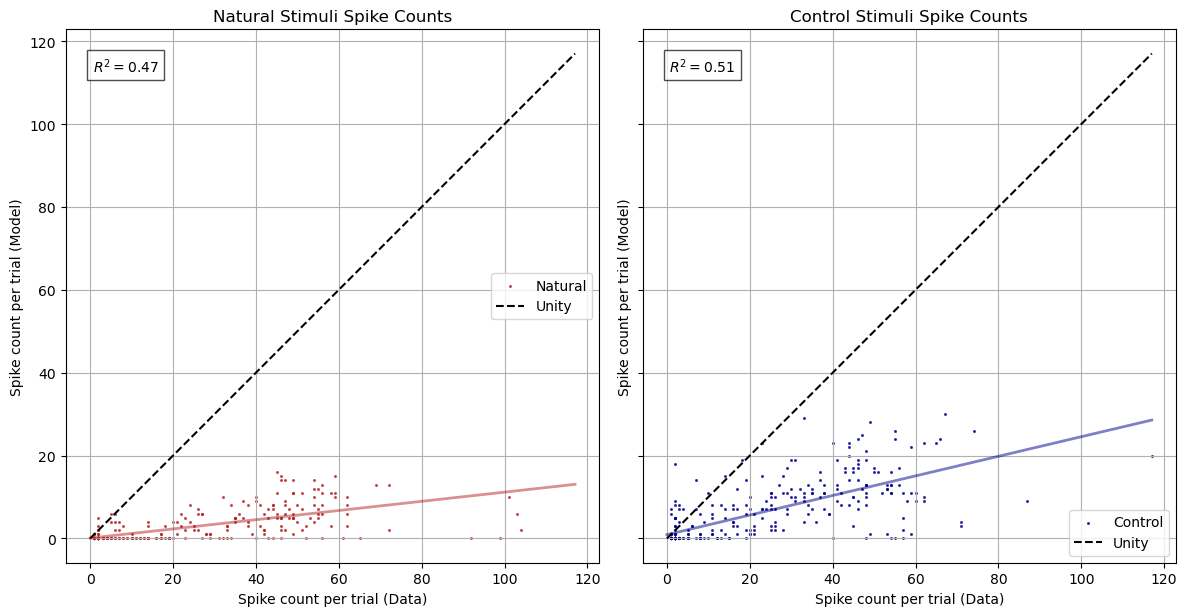

In [22]:
# Natural stimuli data
spike_countsn      = np.array(spike_countsn)
spike_countsnmodel = np.array(spike_countsnmodel)
counts_n     = np.array(spike_countsn)
counts_model_n = np.array(spike_countsnmodel)

# Control stimuli data
spike_countsc      = np.array(spike_countsc)
spike_countscmodel = np.array(spike_countscmodel)
counts_c     = np.array(spike_countsc)
counts_model_c = np.array(spike_countscmodel)

# Compute Pearson's r and R^2 for natural
r_n   = np.corrcoef(counts_n, counts_model_n)[0, 1]
r2_n  = r_n**2

# Compute Pearson's r and R^2 for control
r_c   = np.corrcoef(counts_c, counts_model_c)[0, 1]
r2_c  = r_c**2

# Fit linear regressions
slope_n, intercept_n = np.polyfit(counts_n, counts_model_n, 1)
slope_c, intercept_c = np.polyfit(counts_c, counts_model_c, 1)

# Create subplots with shared axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

# Find global min and max for consistent axis limits
all_counts = np.concatenate([counts_n, counts_model_n, counts_c, counts_model_c])
x_min, x_max = all_counts.min(), all_counts.max()

# Natural stimuli plot (firebrick)
ax1.scatter(counts_n, counts_model_n, marker='.', s=6, alpha=0.7, color='firebrick', label='Natural')
x_vals_n = np.array([x_min, x_max])
y_fit_n  = slope_n * x_vals_n + intercept_n
ax1.plot(x_vals_n, y_fit_n, 'firebrick', linewidth=2, alpha=0.5)

# Unity line for natural
ax1.plot([x_min, x_max], [x_min, x_max], 'k--', label='Unity')

ax1.set_xlabel('Spike count per trial (Data)')
ax1.set_ylabel('Spike count per trial (Model)')
ax1.set_title('Natural Stimuli Spike Counts')
ax1.text(0.05, 0.95, f'$R^2 = {r2_n:.2f}$', 
         transform=ax1.transAxes, ha='left', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7))
ax1.legend()
ax1.grid(True)

# Control stimuli plot (dark blue)
ax2.scatter(counts_c, counts_model_c, marker='.', s=6, alpha=0.7, color='darkblue', label='Control')
x_vals_c = np.array([x_min, x_max])
y_fit_c  = slope_c * x_vals_c + intercept_c
ax2.plot(x_vals_c, y_fit_c, 'darkblue', linewidth=2, alpha=0.5)

# Unity line for control
ax2.plot([x_min, x_max], [x_min, x_max], 'k--', label='Unity')

ax2.set_xlabel('Spike count per trial (Data)')
ax2.set_ylabel('Spike count per trial (Model)')
ax2.set_title('Control Stimuli Spike Counts')
ax2.text(0.05, 0.95, f'$R^2 = {r2_c:.2f}$', 
         transform=ax2.transAxes, ha='left', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7))
ax2.legend()
ax2.grid(True)

# Set equal aspect ratio for both subplots to ensure x and y axes have the same scale
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()


=== NOISE FILTERING STATISTICS ===
Noise threshold: 2 spikes
Natural trials - Original: 339, Filtered: 275, Removed: 64
Control trials - Original: 341, Filtered: 308, Removed: 33


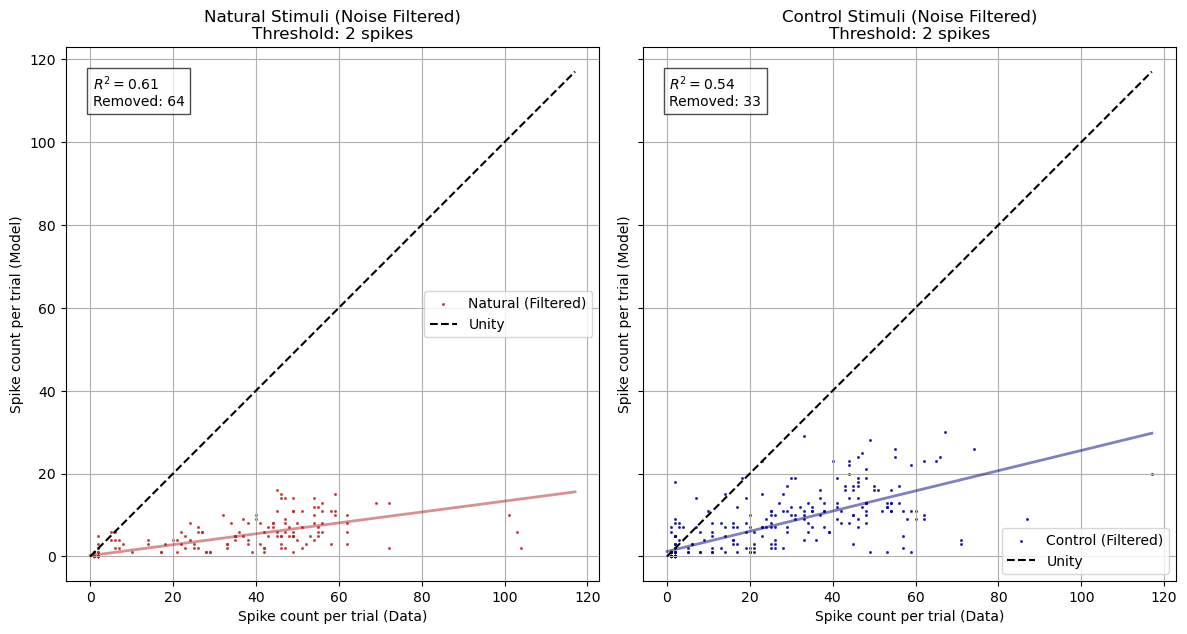


=== CORRELATION COMPARISON ===
Natural stimuli:
  Original R²: 0.468
  Filtered R²:  0.607
  Improvement:  +0.139
Control stimuli:
  Original R²: 0.507
  Filtered R²:  0.541
  Improvement:  +0.034


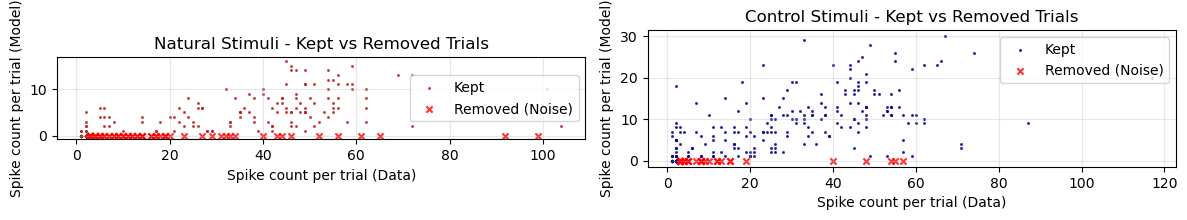

In [23]:
# Filtered spike count comparison - exclude potential noise trials
# Define noise threshold: if model predicts 0 but experiment has > threshold spikes, consider it noise
noise_threshold = 2  # Adjust this value as needed

# Natural stimuli - filter out noise trials
noise_mask_n = ~((counts_model_n == 0) & (counts_n > noise_threshold))
counts_n_filtered = counts_n[noise_mask_n]
counts_model_n_filtered = counts_model_n[noise_mask_n]

# Control stimuli - filter out noise trials  
noise_mask_c = ~((counts_model_c == 0) & (counts_c > noise_threshold))
counts_c_filtered = counts_c[noise_mask_c]
counts_model_c_filtered = counts_model_c[noise_mask_c]

print(f"=== NOISE FILTERING STATISTICS ===")
print(f"Noise threshold: {noise_threshold} spikes")
print(f"Natural trials - Original: {len(counts_n)}, Filtered: {len(counts_n_filtered)}, Removed: {len(counts_n) - len(counts_n_filtered)}")
print(f"Control trials - Original: {len(counts_c)}, Filtered: {len(counts_c_filtered)}, Removed: {len(counts_c) - len(counts_c_filtered)}")

# Compute filtered correlations
r_n_filt = np.corrcoef(counts_n_filtered, counts_model_n_filtered)[0, 1]
r2_n_filt = r_n_filt**2
r_c_filt = np.corrcoef(counts_c_filtered, counts_model_c_filtered)[0, 1]
r2_c_filt = r_c_filt**2

# Fit filtered linear regressions
slope_n_filt, intercept_n_filt = np.polyfit(counts_n_filtered, counts_model_n_filtered, 1)
slope_c_filt, intercept_c_filt = np.polyfit(counts_c_filtered, counts_model_c_filtered, 1)

# Create filtered comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

# Find global min and max for consistent axis limits (filtered data)
all_counts_filt = np.concatenate([counts_n_filtered, counts_model_n_filtered, counts_c_filtered, counts_model_c_filtered])
x_min_filt, x_max_filt = all_counts_filt.min(), all_counts_filt.max()

# Natural stimuli plot (filtered) - firebrick
ax1.scatter(counts_n_filtered, counts_model_n_filtered, marker='.', s=6, alpha=0.7, color='firebrick', label='Natural (Filtered)')
x_vals_n_filt = np.array([x_min_filt, x_max_filt])
y_fit_n_filt = slope_n_filt * x_vals_n_filt + intercept_n_filt
ax1.plot(x_vals_n_filt, y_fit_n_filt, 'firebrick', linewidth=2, alpha=0.5)

# Unity line for natural
ax1.plot([x_min_filt, x_max_filt], [x_min_filt, x_max_filt], 'k--', label='Unity')

ax1.set_xlabel('Spike count per trial (Data)')
ax1.set_ylabel('Spike count per trial (Model)')
ax1.set_title(f'Natural Stimuli (Noise Filtered)\nThreshold: {noise_threshold} spikes')
ax1.text(0.05, 0.95, f'$R^2 = {r2_n_filt:.2f}$\nRemoved: {len(counts_n) - len(counts_n_filtered)}', 
         transform=ax1.transAxes, ha='left', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7))
ax1.legend()
ax1.grid(True)

# Control stimuli plot (filtered) - dark blue
ax2.scatter(counts_c_filtered, counts_model_c_filtered, marker='.', s=6, alpha=0.7, color='darkblue', label='Control (Filtered)')
x_vals_c_filt = np.array([x_min_filt, x_max_filt])
y_fit_c_filt = slope_c_filt * x_vals_c_filt + intercept_c_filt
ax2.plot(x_vals_c_filt, y_fit_c_filt, 'darkblue', linewidth=2, alpha=0.5)

# Unity line for control
ax2.plot([x_min_filt, x_max_filt], [x_min_filt, x_max_filt], 'k--', label='Unity')

ax2.set_xlabel('Spike count per trial (Data)')
ax2.set_ylabel('Spike count per trial (Model)')
ax2.set_title(f'Control Stimuli (Noise Filtered)\nThreshold: {noise_threshold} spikes')
ax2.text(0.05, 0.95, f'$R^2 = {r2_c_filt:.2f}$\nRemoved: {len(counts_c) - len(counts_c_filtered)}', 
         transform=ax2.transAxes, ha='left', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7))
ax2.legend()
ax2.grid(True)

# Set equal aspect ratio
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Print comparison of original vs filtered results
print(f"\n=== CORRELATION COMPARISON ===")
print(f"Natural stimuli:")
print(f"  Original R²: {r2_n:.3f}")
print(f"  Filtered R²:  {r2_n_filt:.3f}")
print(f"  Improvement:  {r2_n_filt - r2_n:+.3f}")
print(f"Control stimuli:")
print(f"  Original R²: {r2_c:.3f}")
print(f"  Filtered R²:  {r2_c_filt:.3f}")
print(f"  Improvement:  {r2_c_filt - r2_c:+.3f}")

# Optional: Create a summary plot showing the distribution of removed trials
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Natural stimuli - show removed trials
ax1.scatter(counts_n[noise_mask_n], counts_model_n[noise_mask_n], marker='.', s=6, alpha=0.7, color='firebrick', label='Kept')
ax1.scatter(counts_n[~noise_mask_n], counts_model_n[~noise_mask_n], marker='x', s=20, alpha=0.8, color='red', label='Removed (Noise)')
ax1.set_xlabel('Spike count per trial (Data)')
ax1.set_ylabel('Spike count per trial (Model)')
ax1.set_title('Natural Stimuli - Kept vs Removed Trials')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Control stimuli - show removed trials
ax2.scatter(counts_c[noise_mask_c], counts_model_c[noise_mask_c], marker='.', s=6, alpha=0.7, color='darkblue', label='Kept')
ax2.scatter(counts_c[~noise_mask_c], counts_model_c[~noise_mask_c], marker='x', s=20, alpha=0.8, color='red', label='Removed (Noise)')
ax2.set_xlabel('Spike count per trial (Data)')
ax2.set_ylabel('Spike count per trial (Model)')
ax2.set_title('Control Stimuli - Kept vs Removed Trials')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.tight_layout()
plt.show()

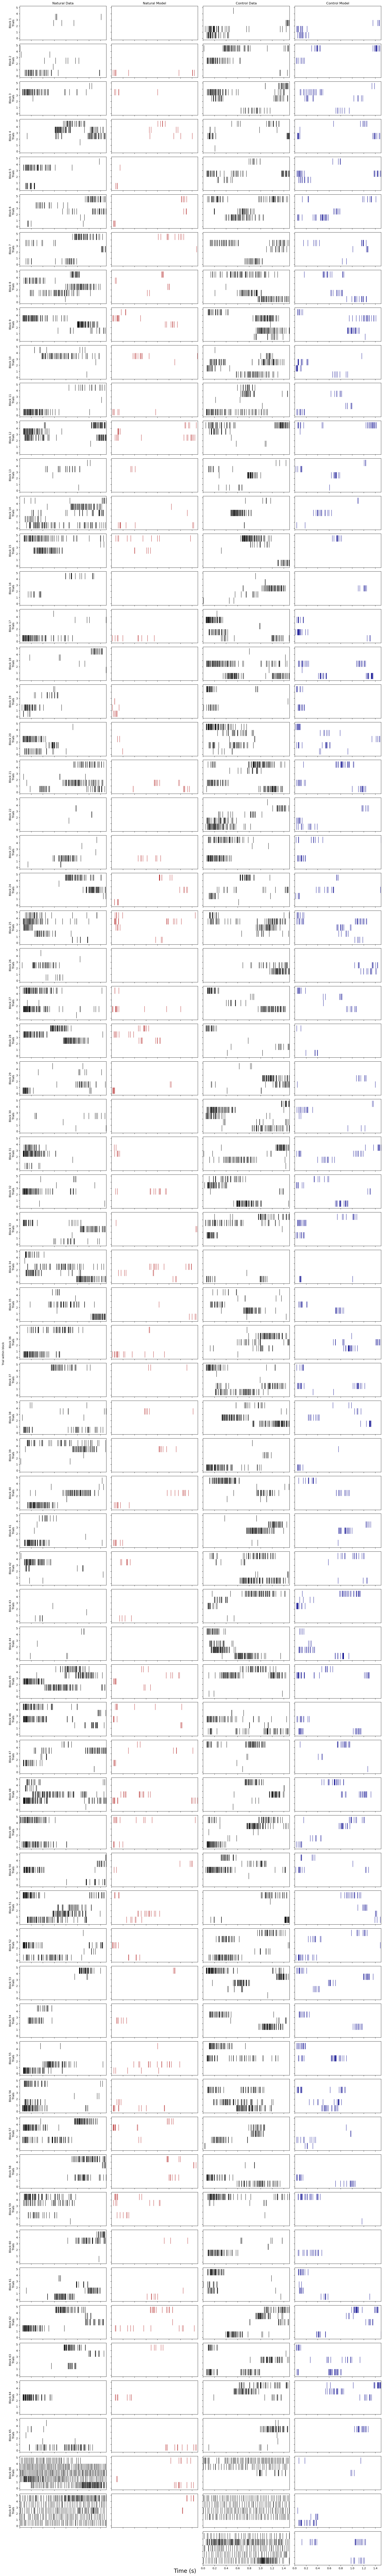

In [24]:

# assume spike_indices_n, spike_indices_c (list of arrays) and spike_trainGCvpfit_n, spike_trainGCvpfit_c are defined
num_trials_n = len(spike_indices_n)
num_trials_c = len(spike_indices_c)
block_size = 5
n_blocks_n = num_trials_n //2 // block_size
n_blocks_c = num_trials_c //2 // block_size
n_blocks = max(n_blocks_n, n_blocks_c)

fig, axes = plt.subplots(n_blocks, 4, figsize=(20, 2*n_blocks), sharex=True, sharey=True)

for b in range(n_blocks):
    # row of axes
    ax_nat, ax_mod_nat, ax_control, ax_mod_control = axes[b]

    # natural trials for this block
    if b < n_blocks_n:
        for k in range(block_size):
            idx = 2*(b*block_size + k)+1    # odd-indexed trials
            t_spk = spike_indices_n[idx] / 10000 - delay
            ax_nat.vlines(t_spk, k, k+1, color='k', linewidth=1)
        ax_nat.set_xlim(0,1.5)
        ax_nat.set_ylabel(f'Block {b+1}\nTrials')
        if b==0: ax_nat.set_title('Natural Data')

        # natural model trials for this block
        for k in range(block_size):
            t_spk = np.array(spike_trainGCvpfit_n[b*block_size + k]) / 1000
            ax_mod_nat.vlines(t_spk, k, k+1, color='firebrick', linewidth=1)
        ax_mod_nat.set_xlim(0,1.5)
        if b==0: ax_mod_nat.set_title('Natural Model')
    else:
        ax_nat.set_visible(False)
        ax_mod_nat.set_visible(False)

    # control trials for this block
    if b < n_blocks_c:
        for k in range(block_size):
            idx = 2*(b*block_size + k)+1    # odd-indexed trials
            t_spk = spike_indices_c[idx] / 10000 - delay
            ax_control.vlines(t_spk, k, k+1, color='k', linewidth=1)
        ax_control.set_xlim(0,1.5)
        if b==0: ax_control.set_title('Control Data')

        # control model trials for this block
        for k in range(block_size):
            t_spk = np.array(spike_trainGCvpfit_c[b*block_size + k]) / 1000
            ax_mod_control.vlines(t_spk, k, k+1, color='darkblue', linewidth=1)
        ax_mod_control.set_xlim(0,1.5)
        if b==0: ax_mod_control.set_title('Control Model')
    else:
        ax_control.set_visible(False)
        ax_mod_control.set_visible(False)

# common labels
fig.text(0.5, 0.05, 'Time (s)', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Trial within block', va='center', rotation='vertical')
plt.tight_layout(rect=(0.05,0.05,1,1))
plt.show()



Time bin: 150 ms

--- Natural Data vs Natural Model ---


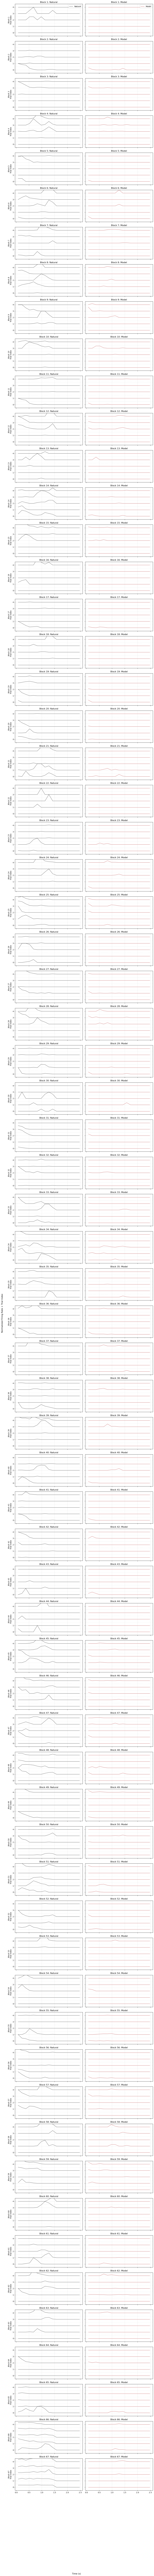

=== BLOCKED PSTH COMPARISON (Time bin: 150 ms) ===
Number of blocks: 67
Trials per block: 5
Total natural trials: 339
Total model trials: 339
Each trial PSTH normalized to global max within block

--- Control Data vs Control Model ---


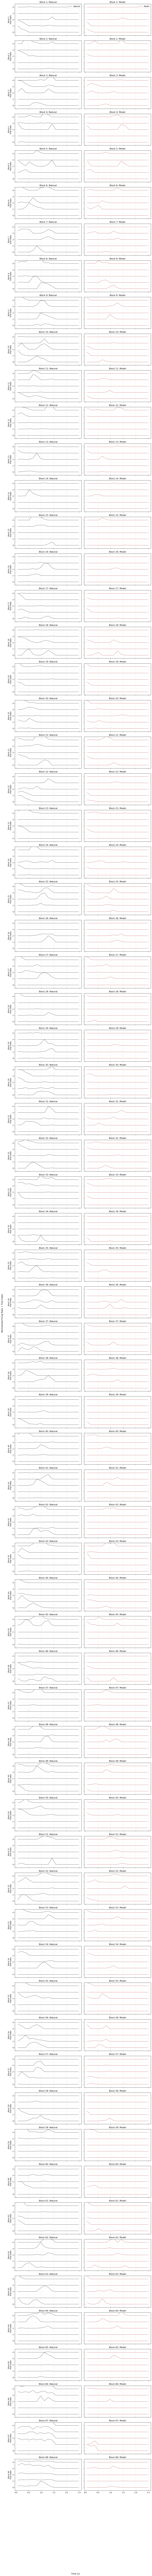

=== BLOCKED PSTH COMPARISON (Time bin: 150 ms) ===
Number of blocks: 68
Trials per block: 5
Total natural trials: 341
Total model trials: 341
Each trial PSTH normalized to global max within block


In [25]:

def plot_psth_comparison(spike_indices_n, spike_trainGCvpfit, time_bin=0.05, delay=0.083, t_start=0, t_end=2.5):
    """
    Plot PSTH comparison between natural and model spike trains with trial-by-trial analysis
    Organized in blocks like the spike raster plot - each trial constrained to 1/5 of block height
    Shows blocks side by side: Natural vs Model for each block
    
    Parameters:
    - time_bin: time bin for firing rate calculation (in seconds)
    - delay: delay offset
    - t_start, t_end: time window for plotting
    """
    
    # Create time bins
    time_bins = np.arange(t_start, t_end + time_bin, time_bin)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    
    # Get natural trials (odd-indexed)
    natural_trial_indices = [idx for idx in range(len(spike_indices_n)) if idx % 2 == 1]
    num_trials = len(natural_trial_indices)
    block_size = 5
    n_blocks = num_trials // block_size
    
    # Create subplot layout - one subplot per block, with Natural and Model side by side
    fig, axes = plt.subplots(n_blocks, 2, figsize=(12, 3*n_blocks), sharex=True, sharey=True)
    if n_blocks == 1:
        axes = axes.reshape(1, -1)
    
    for b in range(n_blocks):
        ax_nat = axes[b, 0]  # Natural trials
        ax_mod = axes[b, 1]  # Model trials
        
        # Store all PSTH values for this block to find global max
        all_psth_values = []
        
        # Natural trials for this block
        for k in range(block_size):
            idx = b * block_size + k
            if idx < len(natural_trial_indices):
                trial_idx = natural_trial_indices[idx]
                t_spk = spike_indices_n[trial_idx] / 10000 - delay
                
                # Calculate PSTH for this trial
                trial_psth = np.zeros(len(bin_centers))
                for i, (bin_start, bin_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                    trial_psth[i] = np.sum((t_spk >= bin_start) & (t_spk < bin_end))
                trial_psth = trial_psth / time_bin
                all_psth_values.append(trial_psth)
        
        # Model trials for this block
        for k in range(block_size):
            if b * block_size + k < len(spike_trainGCvpfit):
                t_spk = np.array(spike_trainGCvpfit[b * block_size + k]) / 1000
                
                # Calculate PSTH for this trial
                trial_psth = np.zeros(len(bin_centers))
                for i, (bin_start, bin_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                    trial_psth[i] = np.sum((t_spk >= bin_start) & (t_spk < bin_end))
                trial_psth = trial_psth / time_bin
                all_psth_values.append(trial_psth)
        
        # Find global max for this block
        if all_psth_values:
            max_values = [np.max(psth) for psth in all_psth_values if np.max(psth) > 0]
            if max_values:
                global_max = np.max(max_values)
            else:
                global_max = 1.0
        else:
            global_max = 1.0
        
        # Plot Natural trials for this block
        for k in range(block_size):
            idx = b * block_size + k
            if idx < len(natural_trial_indices):
                trial_idx = natural_trial_indices[idx]
                t_spk = spike_indices_n[trial_idx] / 10000 - delay
                
                # Calculate PSTH for this trial
                trial_psth = np.zeros(len(bin_centers))
                for i, (bin_start, bin_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                    trial_psth[i] = np.sum((t_spk >= bin_start) & (t_spk < bin_end))
                trial_psth = trial_psth / time_bin
                
                # Normalize PSTH using global max for this block
                if global_max > 0:
                    trial_psth_normalized = trial_psth / global_max
                else:
                    trial_psth_normalized = np.zeros_like(trial_psth)
                
                # Plot with offset for each trial
                y_offset = k
                ax_nat.plot(bin_centers, trial_psth_normalized + y_offset, 'k-', linewidth=1, alpha=0.7, label='Natural' if k == 0 else "")
        
        # Plot Model trials for this block
        for k in range(block_size):
            if b * block_size + k < len(spike_trainGCvpfit):
                t_spk = np.array(spike_trainGCvpfit[b * block_size + k]) / 1000
                
                # Calculate PSTH for this trial
                trial_psth = np.zeros(len(bin_centers))
                for i, (bin_start, bin_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                    trial_psth[i] = np.sum((t_spk >= bin_start) & (t_spk < bin_end))
                trial_psth = trial_psth / time_bin
                
                # Normalize PSTH using global max for this block
                if global_max > 0:
                    trial_psth_normalized = trial_psth / global_max
                else:
                    trial_psth_normalized = np.zeros_like(trial_psth)
                
                # Plot with offset for each trial
                y_offset = k
                ax_mod.plot(bin_centers, trial_psth_normalized + y_offset, 'firebrick', linewidth=1, alpha=0.7, label='Model' if k == 0 else "")
        
        # Set labels and titles for this block
        ax_nat.set_ylabel(f'Block {b+1}\nTrial Index')
        ax_nat.set_title(f'Block {b+1}: Natural')
        ax_nat.set_ylim(-0.5, block_size - 0.5)
        ax_nat.grid(True, alpha=0.3)
        if b == 0:
            ax_nat.legend(loc='upper right')
        
        ax_mod.set_title(f'Block {b+1}: Model')
        ax_mod.set_ylim(-0.5, block_size - 0.5)
        ax_mod.grid(True, alpha=0.3)
        if b == 0:
            ax_mod.legend(loc='upper right')
        
        # Add trial separators
        for k in range(1, block_size):
            ax_nat.axhline(y=k - 0.5, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
            ax_mod.axhline(y=k - 0.5, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
    
    # Common labels
    fig.text(0.5, 0.02, 'Time (s)', ha='center', fontsize=12)
    fig.text(0.02, 0.5, 'Normalized Firing Rate + Trial Index', va='center', rotation='vertical', fontsize=12)
    
    plt.tight_layout(rect=(0.05, 0.05, 1, 1))
    plt.show()
    
    # Calculate and print statistics
    print(f"=== BLOCKED PSTH COMPARISON (Time bin: {time_bin*1000:.0f} ms) ===")
    print(f"Number of blocks: {n_blocks}")
    print(f"Trials per block: {block_size}")
    print(f"Total natural trials: {len(natural_trial_indices)}")
    print(f"Total model trials: {len(spike_trainGCvpfit)}")
    print(f"Each trial PSTH normalized to global max within block")
    
    return bin_centers

# Example usage for both natural and control data
# Plot with different time bins for both natural and control side by side
time_bins_to_try = [0.15]  # 150ms time bin

for time_bin in time_bins_to_try:
    print(f"\n{'='*50}")
    print(f"Time bin: {time_bin*1000:.0f} ms")
    print(f"{'='*50}")

    # Natural data PSTH comparison
    print("\n--- Natural Data vs Natural Model ---")
    bin_centers_nat = plot_psth_comparison(
        spike_indices_n, spike_trainGCvpfit_n, 
        time_bin=time_bin, 
        delay=0.083, 
        t_start=0, 
        t_end=2.5
    )
    
    # Control data PSTH comparison  
    print("\n--- Control Data vs Control Model ---")
    bin_centers_control = plot_psth_comparison(
        spike_indices_c, spike_trainGCvpfit_c, 
        time_bin=time_bin, 
        delay=0.083, 
        t_start=0, 
        t_end=2.5
    ) 

In [26]:
# with h5py.File('stimuli400_nV2.h5', 'r') as f:
#     # f['stimuli'][:] loads the entire dataset as a numpy array
#     movies_c_np = f['stimuli'][:]
#     np.save('V2_stimuli_n.npy', movies_c_np)
# with h5py.File('stimuli400_cV2.h5', 'r') as f:
#     # f['stimuli'][:] loads the entire dataset as a numpy array
#     movies_c_np = f['stimuli'][:]
#     np.save('V2_stimuli_c.npy', movies_c_np)

In [27]:

# Main analysis function
print("=== V2 Natural vs Control Model Optimization Analysis ===")

# Load both datasets
natural_data = load_data('results/V2_natural_counts.pkl')
control_data = load_data('results/V2_control_counts.pkl')

if natural_data is None or control_data is None:
    print("No data to analyze")
else:
    # Print summary for both models
    print("\n--- Natural Model ---")
    print_summary(natural_data)
    print_parameters(natural_data)
    
    print("\n--- Control Model ---")
    print_summary(control_data)
    print_parameters(control_data)
    
    # Create combined optimization convergence plot
    print("\n📈 Creating combined optimization convergence plot...")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot natural model
    iterations_n = natural_data.get('iterationsC', [])
    errors_train_n = natural_data.get('errors_trainC', [])
    errors_eval_n = natural_data.get('errors_evalC', [])
    
    ax1.plot(iterations_n, errors_train_n, 'k-', label='Training Error', linewidth=1)
    ax1.plot(iterations_n, errors_eval_n, 'firebrick', label='Evaluation Error', linewidth=1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Error')
    ax1.set_title('Natural Model Optimization')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot control model
    iterations_c = control_data.get('iterationsC', [])
    errors_train_c = control_data.get('errors_trainC', [])
    errors_eval_c = control_data.get('errors_evalC', [])
    
    ax2.plot(iterations_c, errors_train_c, 'k-', label='Training Error', linewidth=1)
    ax2.plot(iterations_c, errors_eval_c, 'darkblue', label='Evaluation Error', linewidth=1)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Error')
    ax2.set_title('Control Model Optimization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/V2_optimization_convergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Analysis complete!")
    print("Generated files:")
    print("  - V2_optimization_convergence_comparison.png")

=== V2 Natural vs Control Model Optimization Analysis ===
✗ File results/V2_natural_counts.pkl not found
✗ File results/V2_control_counts.pkl not found
No data to analyze


In [28]:

# Main analysis function
print("=== V2 Natural vs Control Model Optimization Analysis ===")

# Load both datasets
natural_data = load_data('results/V2_natural_counts_local.pkl')
control_data = load_data('results/V2_control_counts_local.pkl')

if natural_data is None or control_data is None:
    print("No data to analyze")
else:
    # Print summary for both models
    print("\n--- Natural Model ---")
    print_summary(natural_data)
    print_parameters(natural_data)
    
    print("\n--- Control Model ---")
    print_summary(control_data)
    print_parameters(control_data)
    
    # Create combined optimization convergence plot
    print("\n📈 Creating combined optimization convergence plot...")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot natural model
    iterations_n = natural_data.get('iterationsC', [])
    errors_train_n = natural_data.get('errors_trainC', [])
    errors_eval_n = natural_data.get('errors_evalC', [])
    
    ax1.plot(iterations_n, errors_train_n, 'k-', label='Training Error', linewidth=1)
    ax1.plot(iterations_n, errors_eval_n, 'firebrick', label='Evaluation Error', linewidth=1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Error')
    ax1.set_title('Natural Model Optimization')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot control model
    iterations_c = control_data.get('iterationsC', [])
    errors_train_c = control_data.get('errors_trainC', [])
    errors_eval_c = control_data.get('errors_evalC', [])
    
    ax2.plot(iterations_c, errors_train_c, 'k-', label='Training Error', linewidth=1)
    ax2.plot(iterations_c, errors_eval_c, 'darkblue', label='Evaluation Error', linewidth=1)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Error')
    ax2.set_title('Control Model Optimization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.savefig('results/V2_optimization_convergence_comparison_local.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Analysis complete!")
    print("Generated files:")
    print("  - V2_optimization_convergence_comparison_local.png")

=== V2 Natural vs Control Model Optimization Analysis ===
✗ File results/V2_natural_counts_local.pkl not found
✗ File results/V2_control_counts_local.pkl not found
No data to analyze
